In [2]:
#from climaf.api import *

import os, glob, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns

from scipy import signal

#clog('critical') 
import re

# To load personal libraries (currently in folder 'tools'):
sys.path.append('tools')

import generic_tools_pl as gt   # like hexcolor(), ...


* CHOIX DE LA REGION A TRAITER 


In [3]:
region="50"

In [3]:
all_models=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
            'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
            'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
            'NorESM2-LM']

# Data Preparation

In [4]:
# Chemin absolu du dossier "projetlong"
PROJETLONG_PATH = '/Users/dahmani/Desktop/GitPL'

# Chemin absolu du dossier "region48" ou "region50"
data_dir = "/Users/dahmani/Desktop/GitPL/data_source_dr/region{}".format(region)

* Visualiser Le dataset

In [35]:

# Open the .nc file using xarray
ds = xr.open_dataset('/Users/dahmani/Desktop/GitPL/region48/MIROC6_hist-nat_Reg_region48.nc')
# Convert the dataset to a Pandas DataFrame
df = ds.to_dataframe().reset_index()
# Print the DataFrame
df

time  height  region abbrevs                     names  \
0   1850-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
1   1851-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
2   1852-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
3   1853-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
4   1854-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
..                  ...     ...     ...     ...                       ...   
160 2010-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
161 2011-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
162 2012-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
163 2013-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   
164 2014-07-01 06:00:00     2.0      48     EPO  Equatorial.Pacific-Ocean   

     tas_r10i1p1f1_ano  tas_r11i1p1f1_ano  tas_r12i1p1f1_ano  \
0             0.368683           0.347013          -0.381859   
1             1.304867          -0.836082           0.195356   
2             0.238862          -0.806265           0.352013   
3            -0.924709          -0.244760           0.383775   
4            -0.393633           0.300581           0.487239   
..                 ...                ...                ...   
160          -0.569996           0.032888           0.039580   
161          -0.523152          -0.485519           0.430829   
162           0.183970           0.294595           0.813453   
163          -0.164593           0.088366           1.245918   
164           0.259715          -0.336370           0.034868   

     tas_r13i1p1f1_ano  tas_r14i1p1f1_ano  ...  tas_r47i1p1f1_ano  \
0            -0.016979       3.160802e-01  ...          -0.205883   
1             0.465787      -1.414029e-01  ...          -0.064460   
2             0.227786       3.973209e-01  ...           0.287275   
3             0.340703       1.045912e+00  ...           0.799106   
4             0.914739       2.259217e-01  ...           1.171089   
..                 ...                ...  ...                ...   
160          -0.158320       9.969210e+36  ...           0.332389   
161          -0.164201       9.969210e+36  ...           0.597886   
162           0.787596       9.969210e+36  ...           0.797422   
163           0.738894       9.969210e+36  ...           0.072095   
164           0.242768       9.969210e+36  ...          -0.160190   

     tas_r48i1p1f1_ano  tas_r49i1p1f1_ano  tas_r4i1p1f1_ano  \
0            -0.668628           0.941885          1.230066   
1            -0.464764           0.718581          0.382888   
2             0.711162          -0.184250         -0.975684   
3             1.051387          -0.346319         -0.531524   
4            -0.143270           0.283111         -0.254881   
..                 ...                ...               ...   
160          -0.411191          -0.015798         -0.727550   
161           0.247694          -0.645659         -0.694404   
162           0.339915          -0.460697         -0.413065   
163           0.188136           0.460073          0.125519   
164           0.280292           0.855831          0.304362   

     tas_r50i1p1f1_ano  tas_r5i1p1f1_ano  tas_r6i1p1f1_ano  tas_r7i1p1f1_ano  \
0             0.174062      9.613701e-01         -0.504811         -0.769272   
1            -0.059194      2.971585e-01         -0.667909         -0.624045   
2             0.186425     -4.508146e-01          0.470264         -0.199416   
3             0.817185     -4.120804e-01          0.029243          0.492953   
4            -0.043023      3.425747e-01         -0.178023          0.672822   
..                 ...               ...               ...               ...   
160           0.479237      9.969210e+36          0.624495          0.583758   
161           0.000405      9.969210e+36          0.506378          0.945458   
162          -0.028

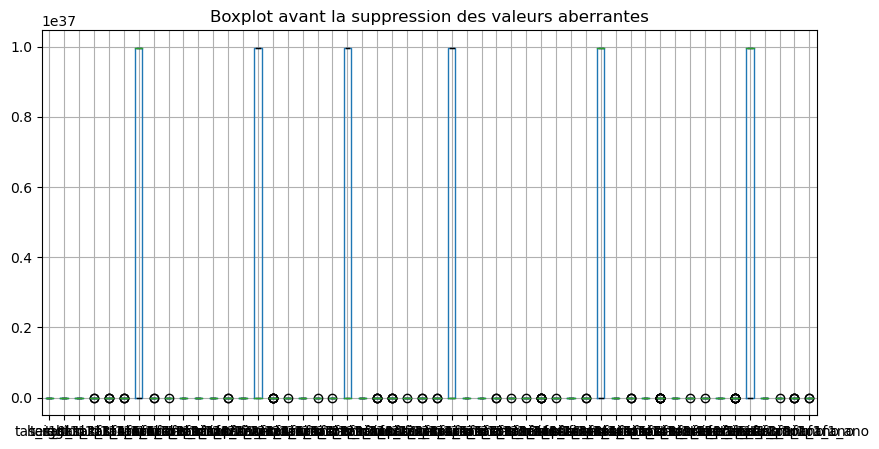

In [37]:
plt.figure(figsize=(10, 5))
plt.title("Boxplot avant la suppression des valeurs aberrantes")
df.boxplot()
plt.show()

In [8]:
# liste de modeles climatiques, triée par ordre alphabetique
data_dir_="/Users/dahmani/Desktop/stagelong/projetlong/region{}".format(region)
all_models = []
all_nc_files = np.sort(glob.glob(os.path.join(data_dir_,'*_hist-GHG_Reg_region{}.nc'.format(region))))

for f in np.sort(all_nc_files):
    basename = os.path.basename(f)
    #fname = basename.strip('_hist-GHG_Reg.nc')  # retire '_hist-GHG_Reg.nc' au nom de chaque fichier pour ne garder que le nom du modele climatique
    fname = basename.split('_')[0]  # prend le premier decoupage du nom du fichier, decoupant par '_', et qui correspond au nom du modele
    print(f,os.path.basename(f),fname)
    all_models.append(fname)

print(f"{len(all_models)} models found:\n {all_models}")

/Users/dahmani/Desktop/stagelong/projetlong/region50/ACCESS-ESM1-5_hist-GHG_Reg_region50.nc ACCESS-ESM1-5_hist-GHG_Reg_region50.nc ACCESS-ESM1-5
/Users/dahmani/Desktop/stagelong/projetlong/region50/BCC-CSM2-MR_hist-GHG_Reg_region50.nc BCC-CSM2-MR_hist-GHG_Reg_region50.nc BCC-CSM2-MR
/Users/dahmani/Desktop/stagelong/projetlong/region50/CESM2_hist-GHG_Reg_region50.nc CESM2_hist-GHG_Reg_region50.nc CESM2
/Users/dahmani/Desktop/stagelong/projetlong/region50/CNRM-CM6-1_hist-GHG_Reg_region50.nc CNRM-CM6-1_hist-GHG_Reg_region50.nc CNRM-CM6-1
/Users/dahmani/Desktop/stagelong/projetlong/region50/CanESM5_hist-GHG_Reg_region50.nc CanESM5_hist-GHG_Reg_region50.nc CanESM5
/Users/dahmani/Desktop/stagelong/projetlong/region50/FGOALS-g3_hist-GHG_Reg_region50.nc FGOALS-g3_hist-GHG_Reg_region50.nc FGOALS-g3
/Users/dahmani/Desktop/stagelong/projetlong/region50/GISS-E2-1-G_hist-GHG_Reg_region50.nc GISS-E2-1-G_hist-GHG_Reg_region50.nc GISS-E2-1-G
/Users/dahmani/Desktop/stagelong/projetlong/region50/HadGEM3

#### Filtrage des Regions et visualisation avec valeurs abberrentes 

In [7]:
# Chemin d'accès vers les fichiers de modèle climatique
chemin_dacces = "/Users/dahmani/Desktop/GitPL/Projet-long-2022-2023/*.nc"

nouveau_dossier = f"/Users/dahmani/Desktop/GitPL/region{region}"
if not os.path.exists(nouveau_dossier):
    os.mkdir(nouveau_dossier)

# Boucle pour parcourir tous les fichiers de modèle climatique
for fichier in glob.glob(chemin_dacces):
    # Charger le fichier de modèle climatique dans un objet Dataset
    ds = xr.open_dataset(fichier)

    # Extraire les données de la zone spécifiée
    zone_region = ds.sel(region=int(region))

# Écrire les données de la zone dans un nouveau fichier dans le nouveau dossier créé
    nouveau_fichier = os.path.join(nouveau_dossier, os.path.basename(fichier)[:-3] + f"_region{region}.nc")
    zone_region.to_netcdf(nouveau_fichier)


In [10]:
data_dir = '/Users/dahmani/Desktop/GitPL/region{}'.format(region)
# Exemple de lecture du forcage GHG ...
#  Lecture des profils d’anomalies de température de l'air, forcage GHG, pour tous les modeles
all_models=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                             'NorESM2-LM']
all_forcings = ['GHG', 'AER', 'NAT', 'HIST']
all_forc_file_ext = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

results_dict = {}

for model_name in all_models:
    model_dict = {}
    for forcing, forc_in_fname in zip(all_forcings, all_forc_file_ext):
        forcings_filename = f'{model_name}_{forc_in_fname}_Reg_region{region}.nc'
        
        profilsT_ds = xr.open_dataset(os.path.join(data_dir, forcings_filename))
        
        # comment savoir quelles variables de données dans le Dataset ?
        # c'est aussi la liste de membres du même forcage pour le modele en question
        list_nc_var = list(profilsT_ds.keys())

        model_dict[forcing] = len(list_nc_var)
        
        #del(profilsT_ds)
    results_dict[model_name] = model_dict

df = pd.DataFrame(results_dict)

All_sim=df.values
models=df.columns
forcings=df.index

# Chemin de sortie pour les fichiers
out_dir = '/Users/dahmani/Desktop/GitPL/Out-My-nb-1'

# Créer un répertoire pour la région si celui-ci n'existe pas encore
region_dir = os.path.join(out_dir, "region{}".format(region))
if not os.path.exists(region_dir):
    os.makedirs(region_dir)

# Enregistrer All_sim_z48v0 comme fichier .p dans le répertoire de la région
with open(os.path.join(region_dir, "All_sim_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(All_sim, f)

# Enregistrer models_z48v0 comme fichier .p dans le répertoire de la région
with open(os.path.join(region_dir, "models_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(models.tolist(), f)

# Enregistrer forcings_z48v0 comme fichier .p dans le répertoire de la région
with open(os.path.join(region_dir, "forcings_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(forcings.tolist(), f)

In [11]:
# Chemin d'accès vers les fichiers NetCDF
chemin_dacces = "/Users/dahmani/Desktop/GitPL/region{}/*.nc".format(region)

# Liste des types de forçage
types_forçage = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

# Liste des noms de modèles
noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM']

# Boucle pour parcourir tous les types de forçage
for forçage in types_forçage:
    # Dictionnaire pour stocker les dataframes pour chaque modèle
    df_dict = {}

    # Boucle pour parcourir tous les fichiers NetCDF correspondant au type de forçage
    for fichier in glob.glob(f"/Users/dahmani/Desktop/GitPL/region{region}/*_{forçage}_*_*.nc"):
        # Extraire le nom du modèle à partir du nom de fichier
        modele = [nom_modele for nom_modele in noms_modeles if nom_modele in fichier][0]

        # Vérifier si le modèle existe déjà dans le dictionnaire
        if modele not in df_dict:
            # Si le modèle n'existe pas, créer un nouveau dataframe
            df_dict[modele] = pd.DataFrame()

        # Ouvrir le fichier NetCDF et extraire les données
        ds = xr.open_dataset(fichier)
        df = ds.to_dataframe().reset_index()
        # print(df.iloc[:, :5].columns.values.tolist())
        df = df.loc[:,(list(ds.keys()))]
        df = df.transpose().reset_index().rename(columns={'index': 'Variable'})
        # Ajouter les données au dataframe correspondant
        df['modele'] = modele
        df_dict[modele] = pd.concat([df_dict[modele], df])

    # Vérifier si au moins un modèle a été traité pour le type de forçage
    if df_dict:
        # Vérifier si chaque dataframe pour le modèle contient des données
        df_dict_filtered = {k: v for k, v in df_dict.items() if not v.empty}
#       Trier les dataframes de chaque modèle en fonction de l'ordre des modèles
        df_dict_sorted = {modele: df_dict_filtered[modele] for modele in noms_modeles if modele in df_dict_filtered}
        # Concaténer les dataframes de tous les modèles pour le type de forçage
        df_concat = pd.concat(df_dict_sorted.values())
        # Add the 'modele' column as the first column
        df_concat.insert(0, 'modele', df_concat.pop('modele'))    
        # Écrire le dataframe dans un fichier CSV
        fichier_sortie = f"/Users/dahmani/Desktop/GitPL/Out-My-nb-1/region{region}/{forçage}_{region}.csv"
        df_concat.to_csv(fichier_sortie, index=False)

        print(f"Données pour le type de forçage {forçage}: {df_concat.shape}")
    else:
        # Afficher un message d'avertissement si aucun modèle n'a été trouvé pour le type de forçage
        print(f"Aucun modèle trouvé pour le type de forçage {forçage}")

Données pour le type de forçage hist-GHG: (103, 167)
Données pour le type de forçage hist-aer: (89, 167)
Données pour le type de forçage hist-nat: (160, 167)
Données pour le type de forçage historical: (256, 167)


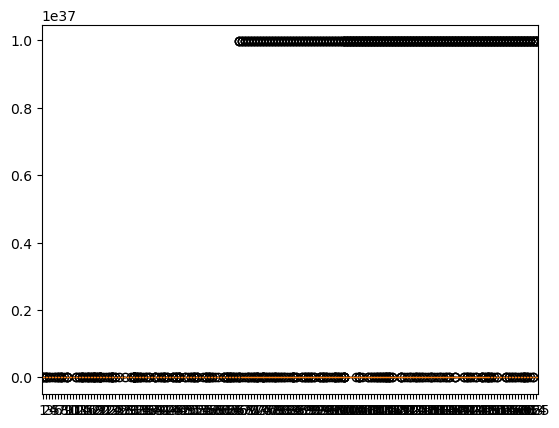

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV
df = pd.read_csv('/Users/dahmani/Desktop/GitPL/Out-My-nb-1/region48/hist-nat_48.csv')

# Supprimer les deux premières colonnes
df = df.iloc[:, 2:]

# Créer un box plot des données restantes
plt.boxplot(df.values)
plt.show()

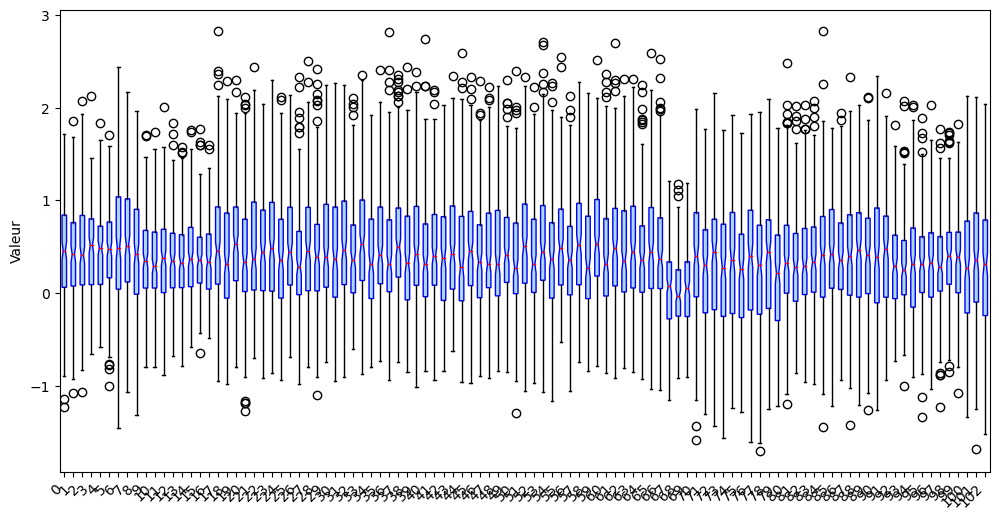

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le fichier CSV
df = pd.read_csv('/Users/dahmani/Desktop/GitPL/Out-My-nb-1/region48/hist-GHG_48.csv')

# Supprimer les deux premières colonnes
df = df.iloc[:, 2:]
df = df.T
# Créer un box plot pour chaque colonne
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(df.values, patch_artist=True, notch=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='red'))

# Personnaliser les labels et l'axe des ordonnées
ax.set_xticklabels(df.columns, rotation=45, ha='right')
ax.set_ylabel('Valeur')

# Ajouter une légende pour le box plot
box_colors = ['lightblue']*len(df.columns)
box_colors[0] = 'blue'
handles = [plt.Rectangle((0,0),1,1, color=box_colors[i]) for i in range(len(df.columns))]
labels = df.columns
# ax.legend(handles, labels, loc='upper right')

plt.show()



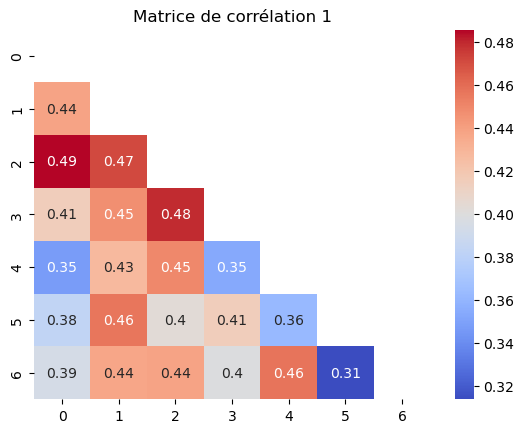

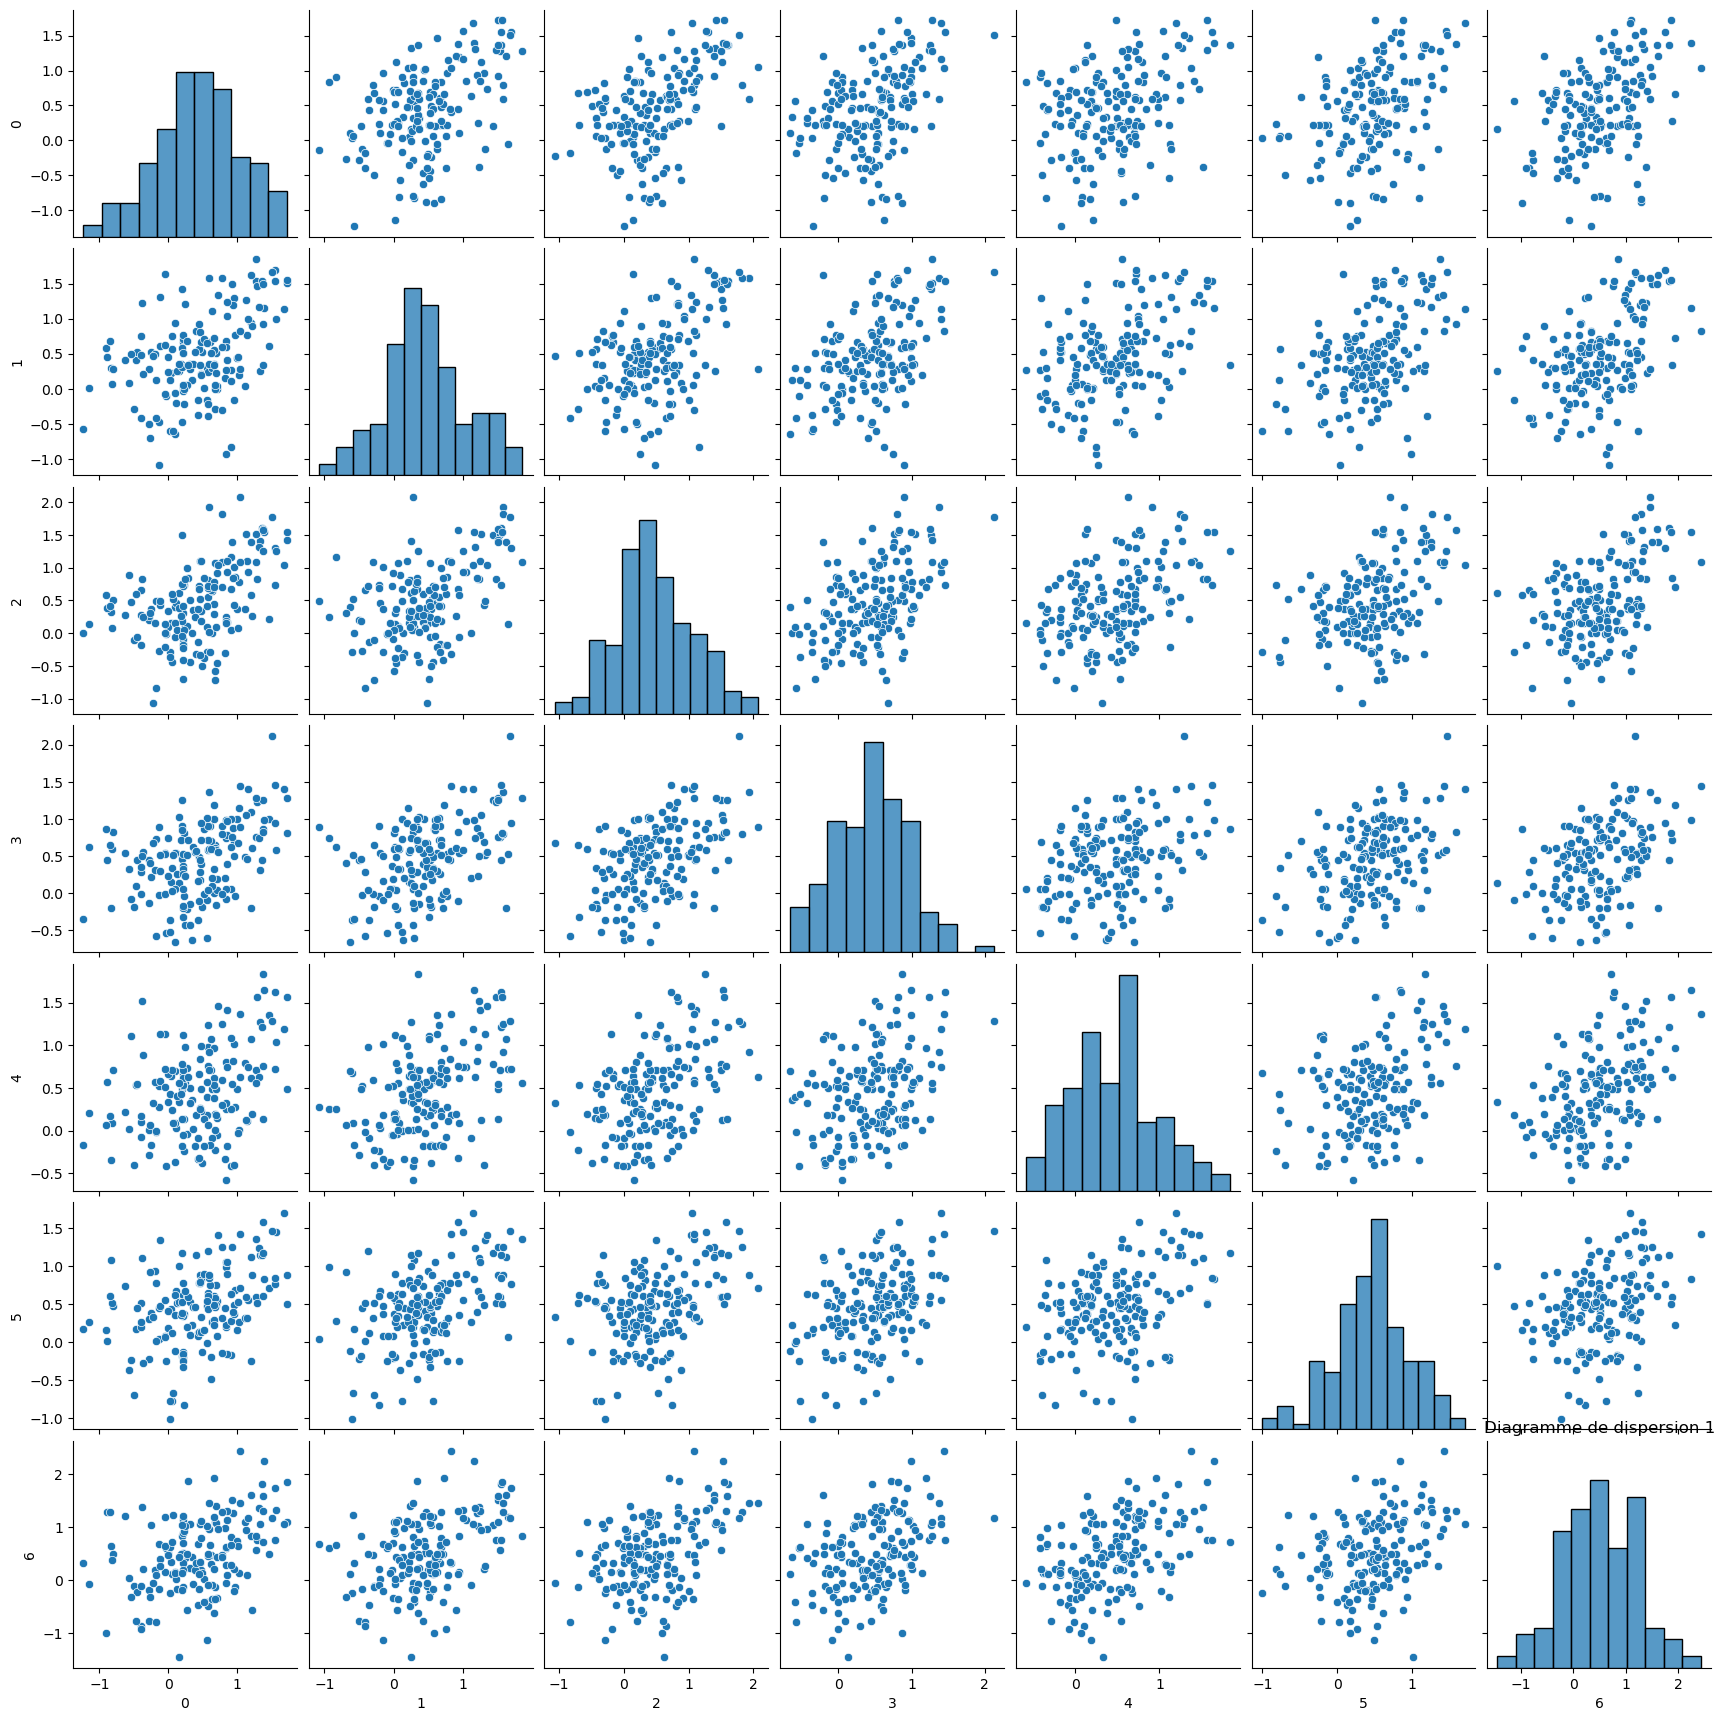

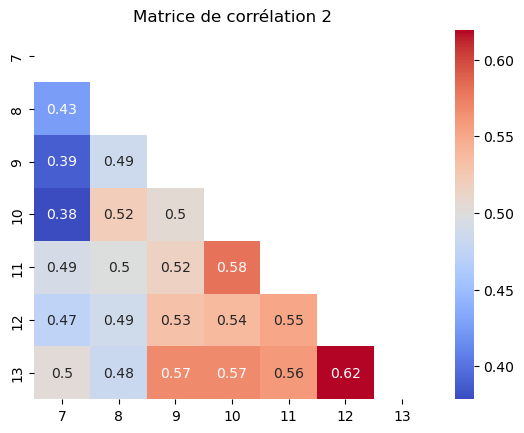

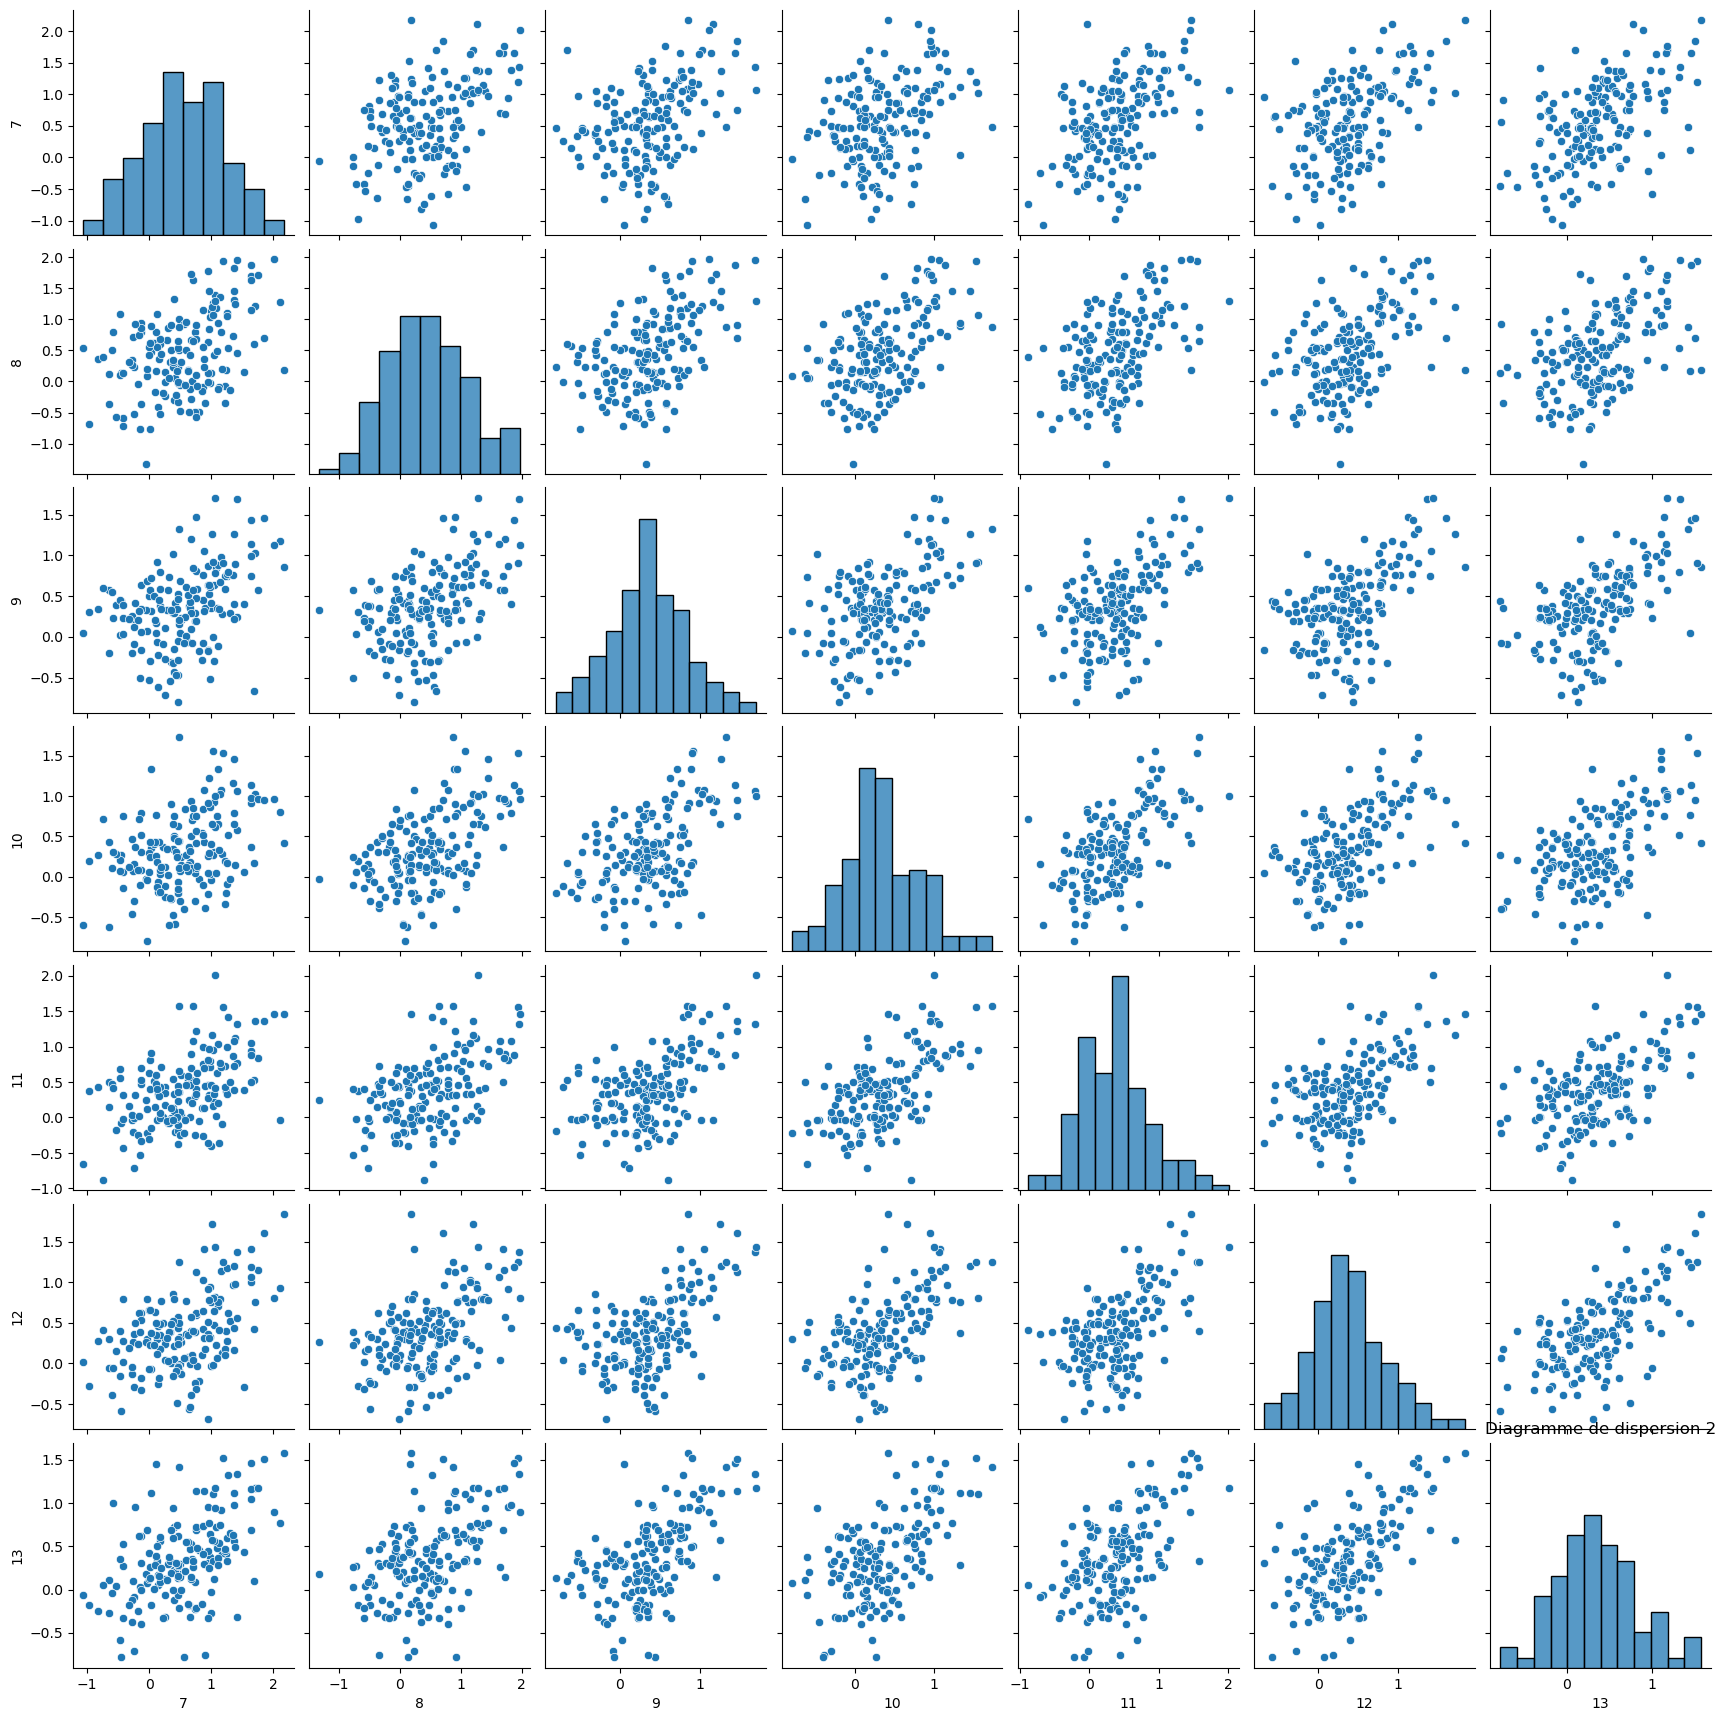

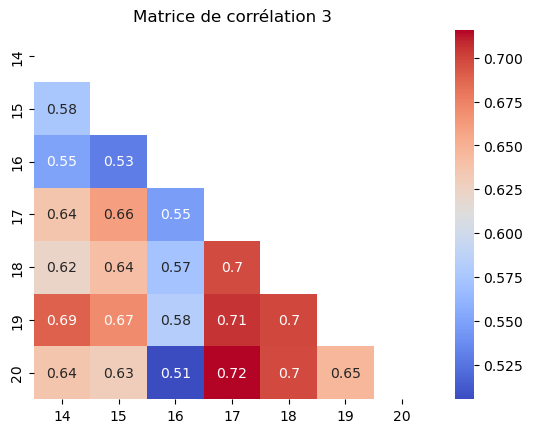

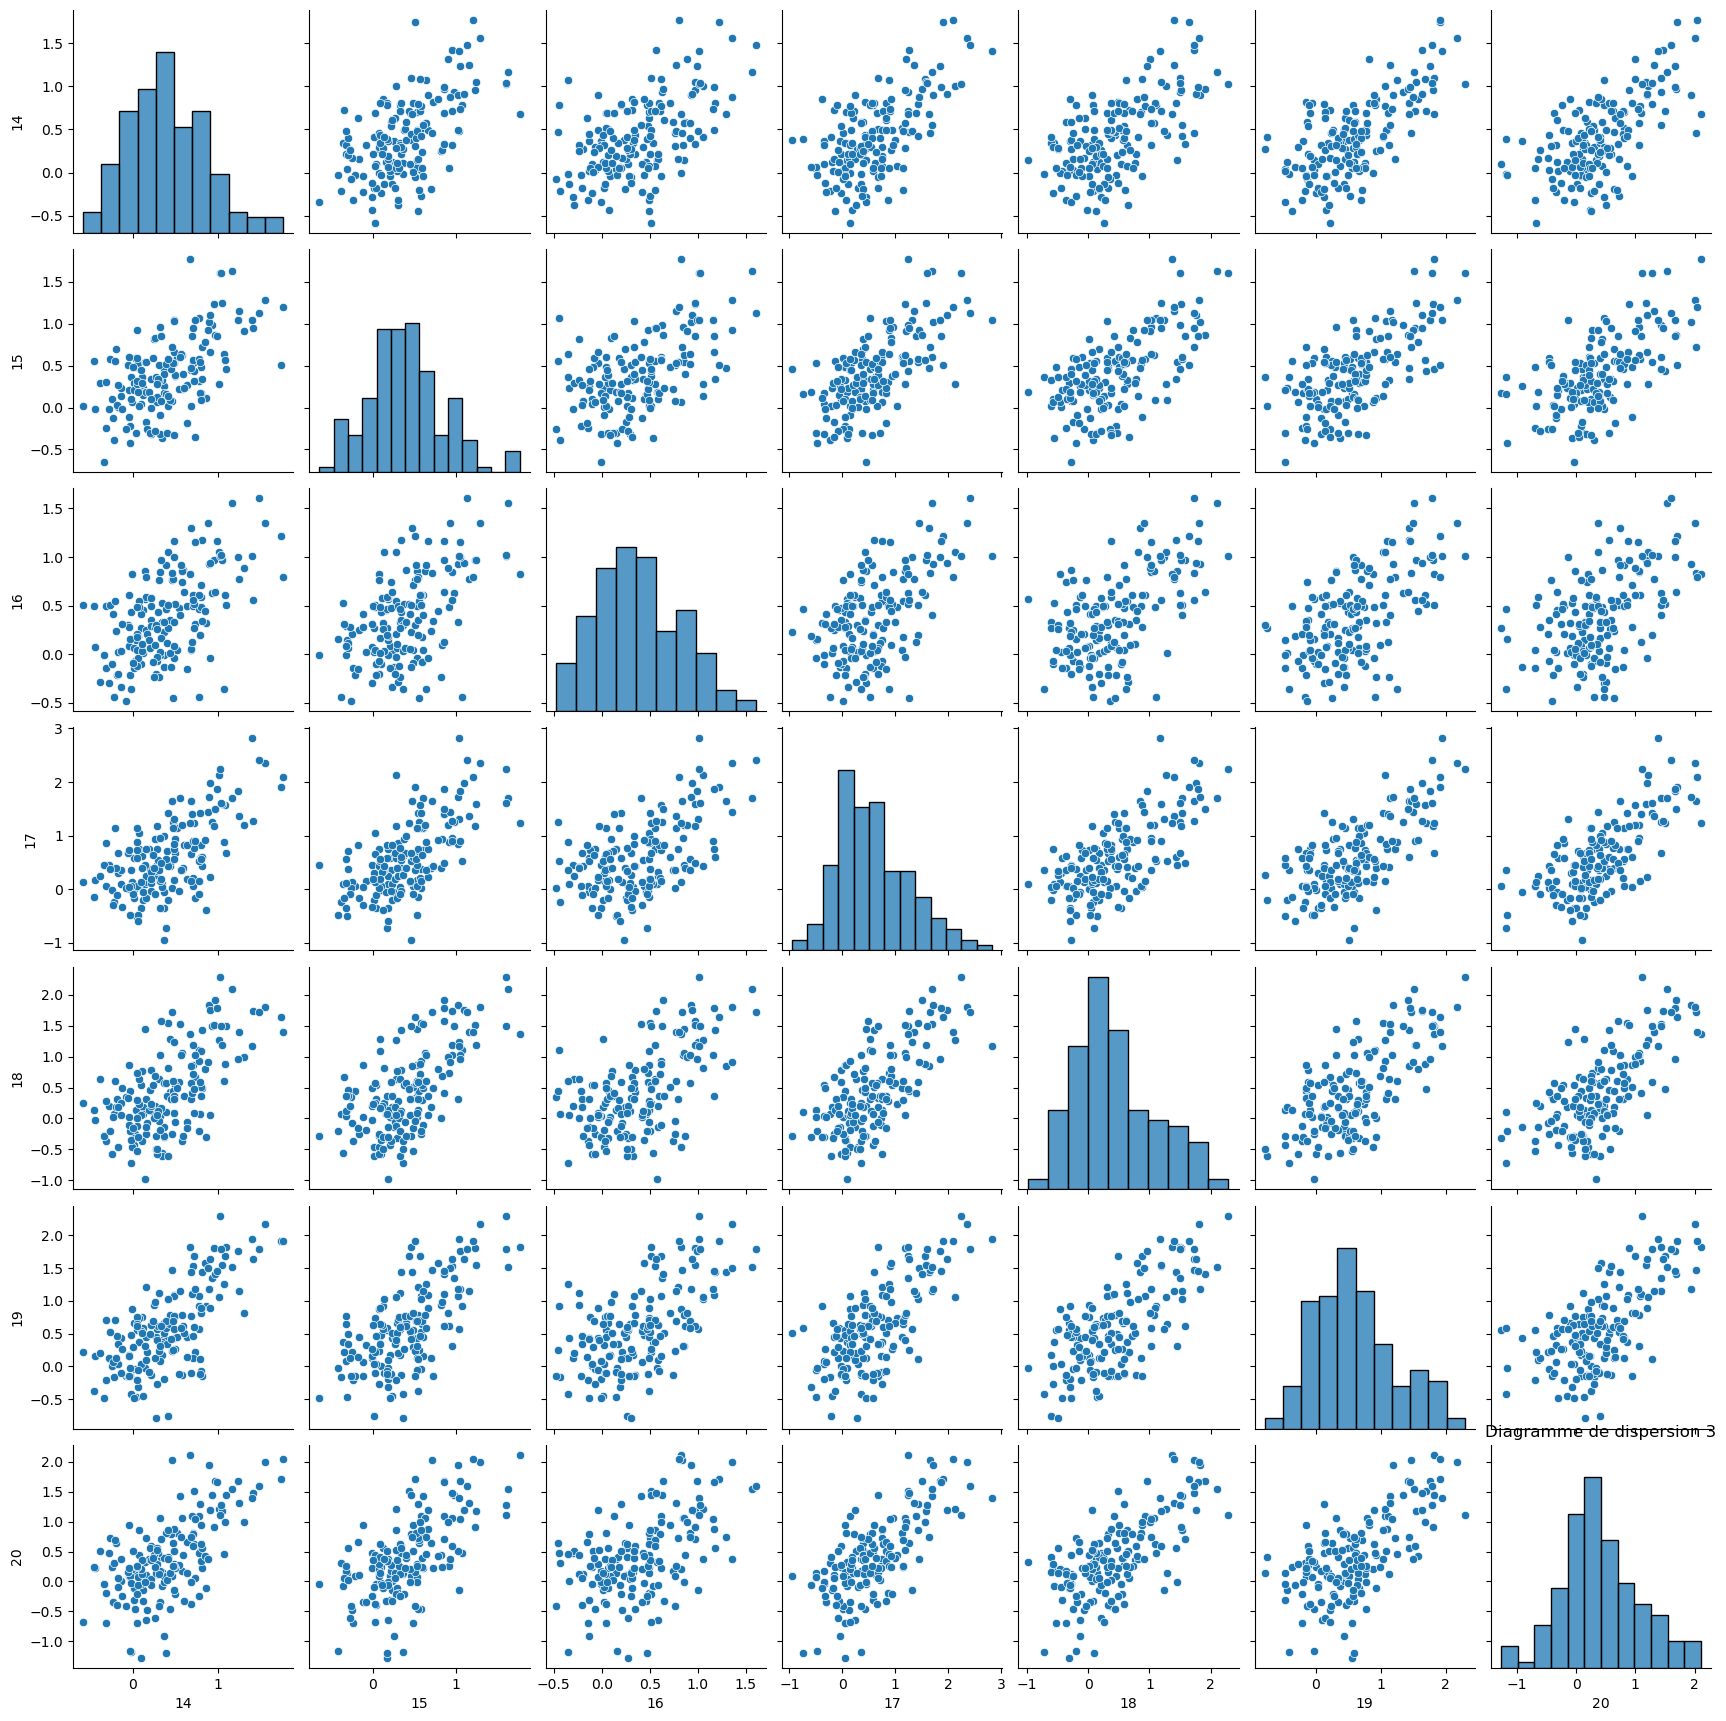

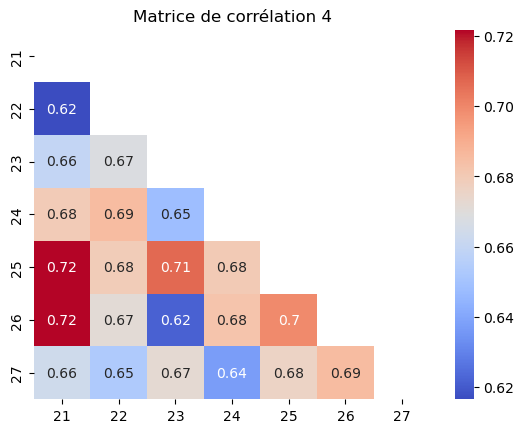

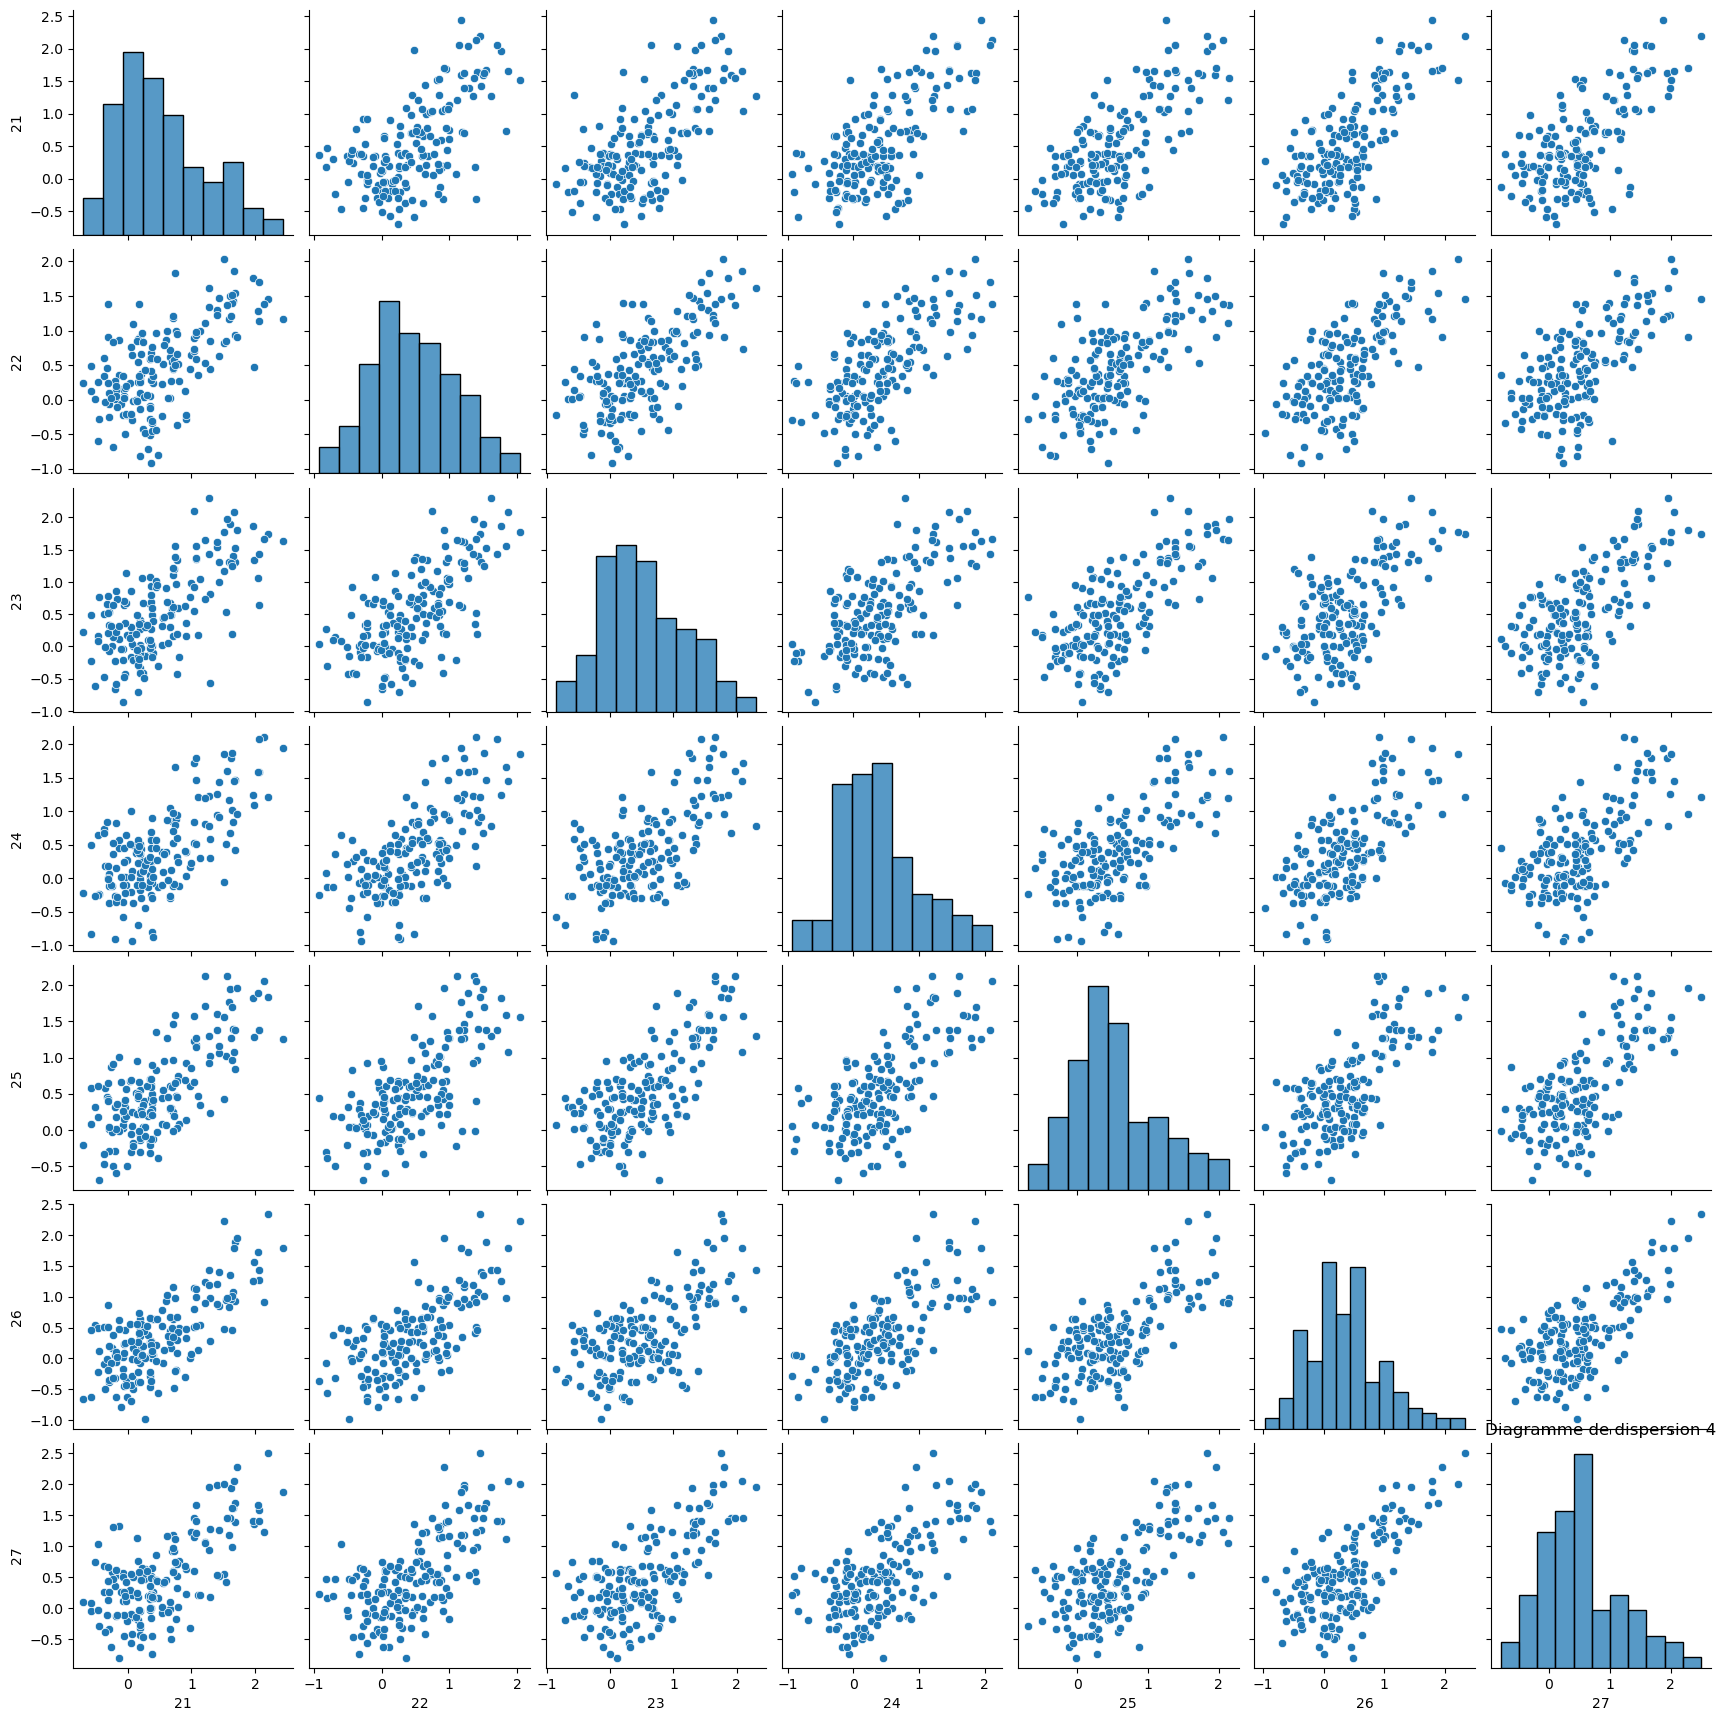

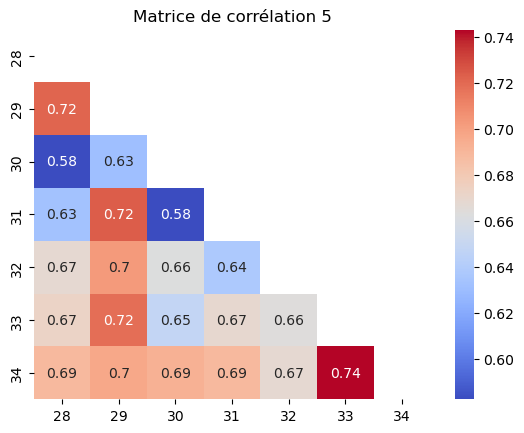

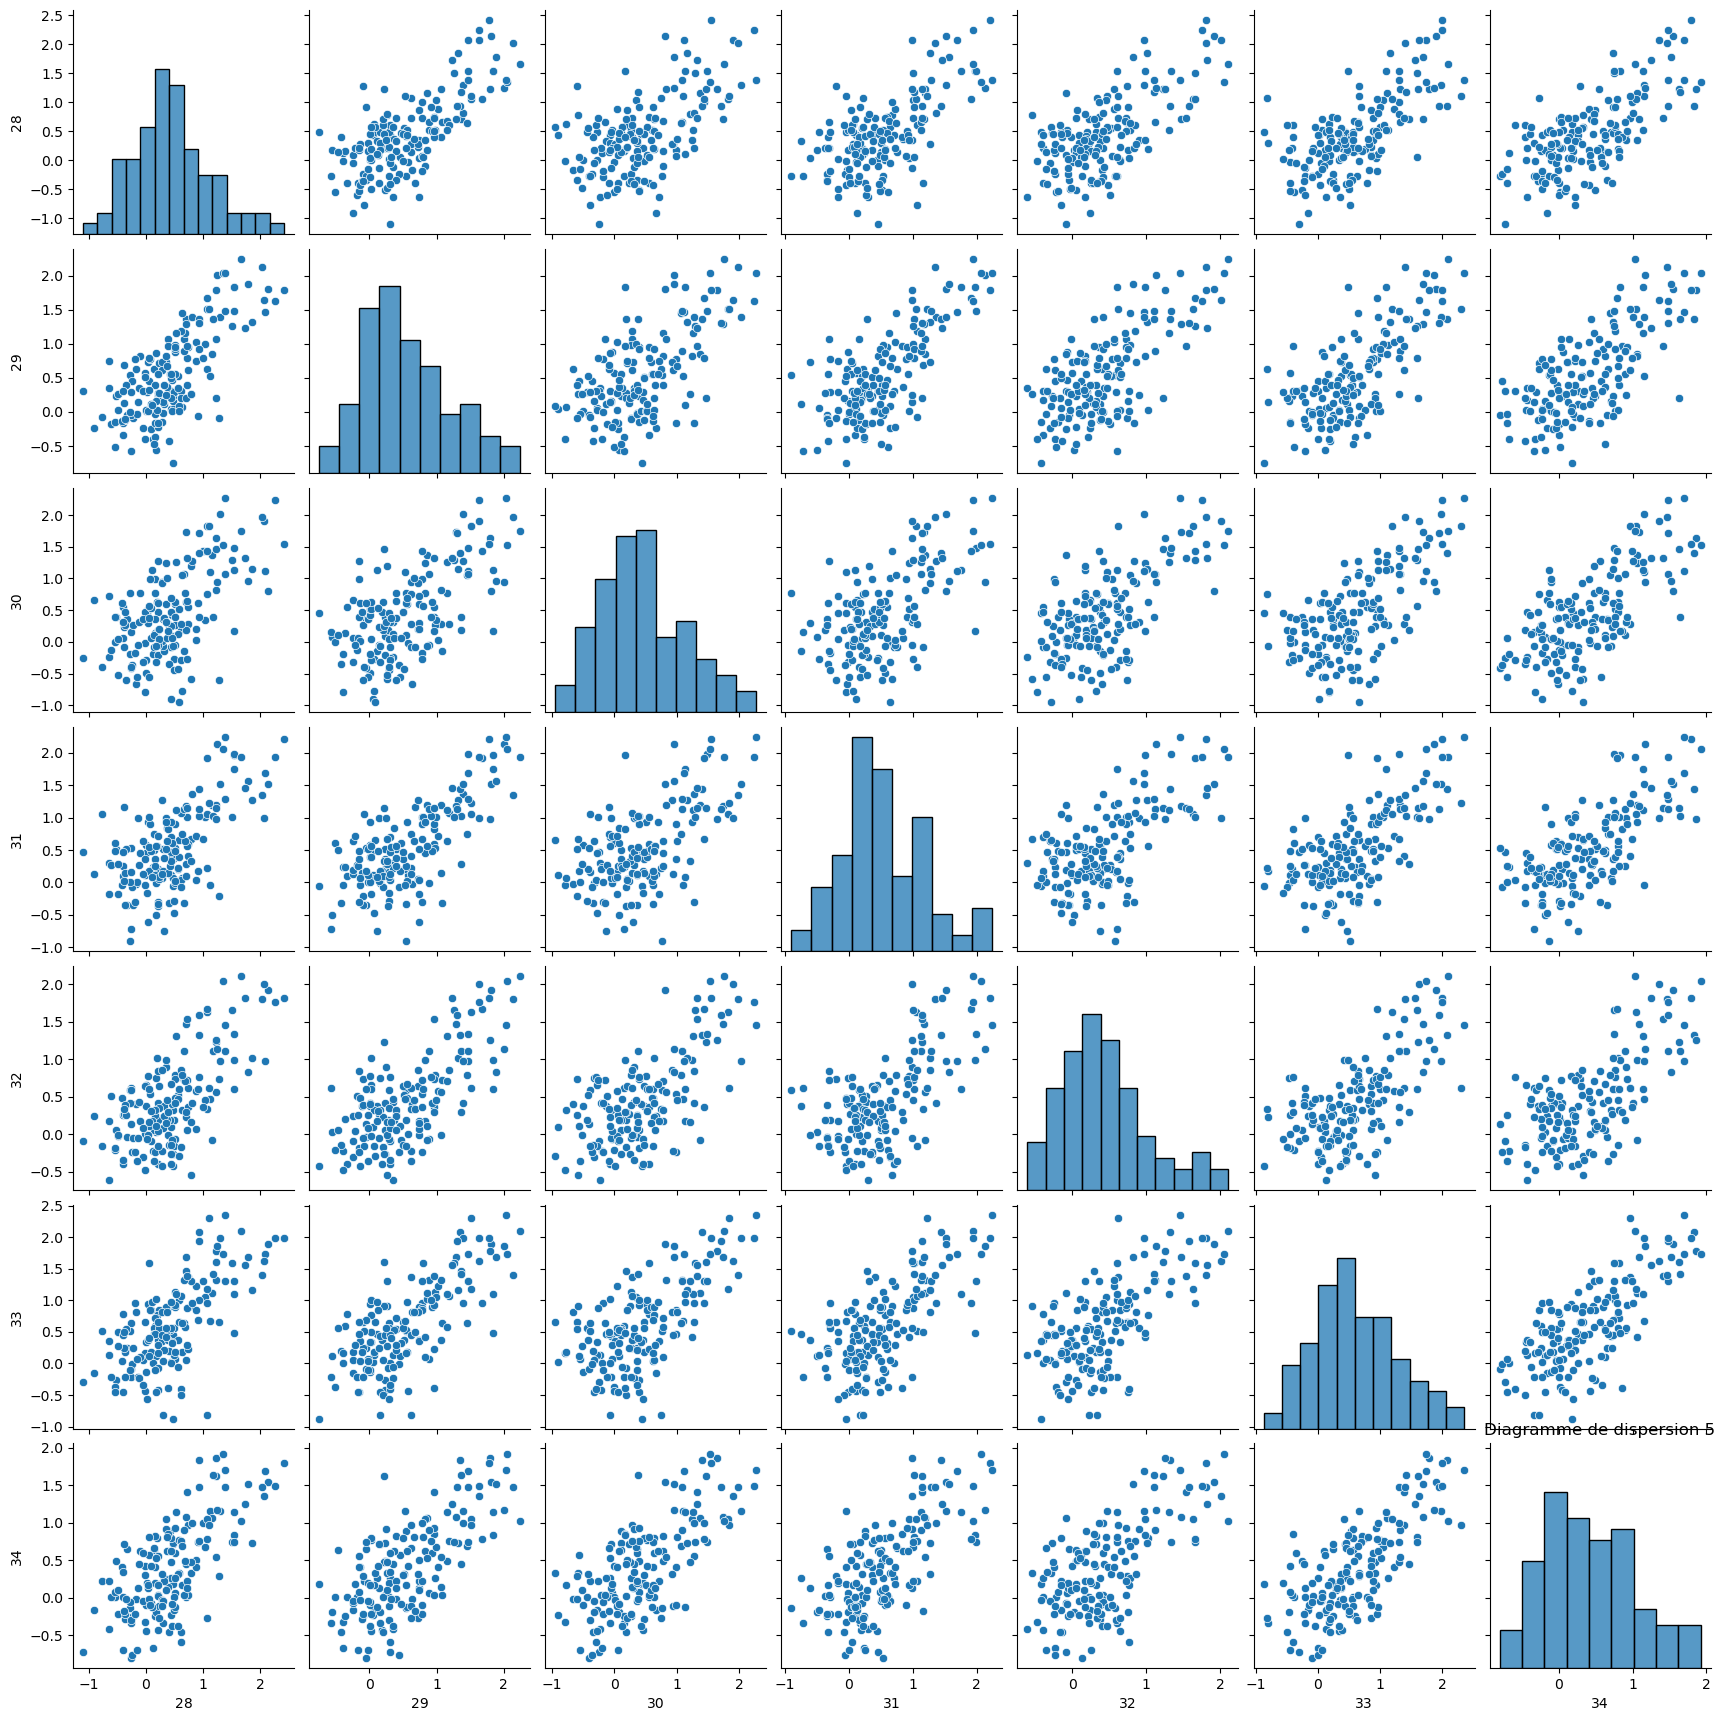

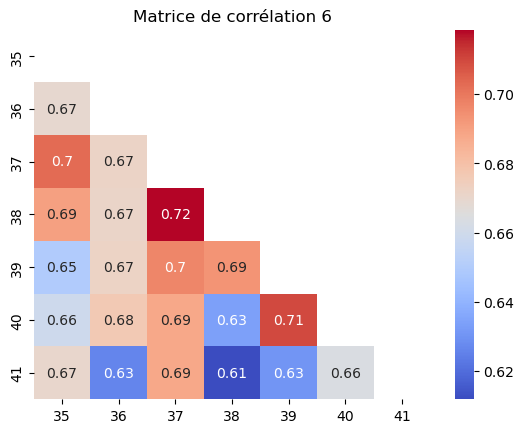

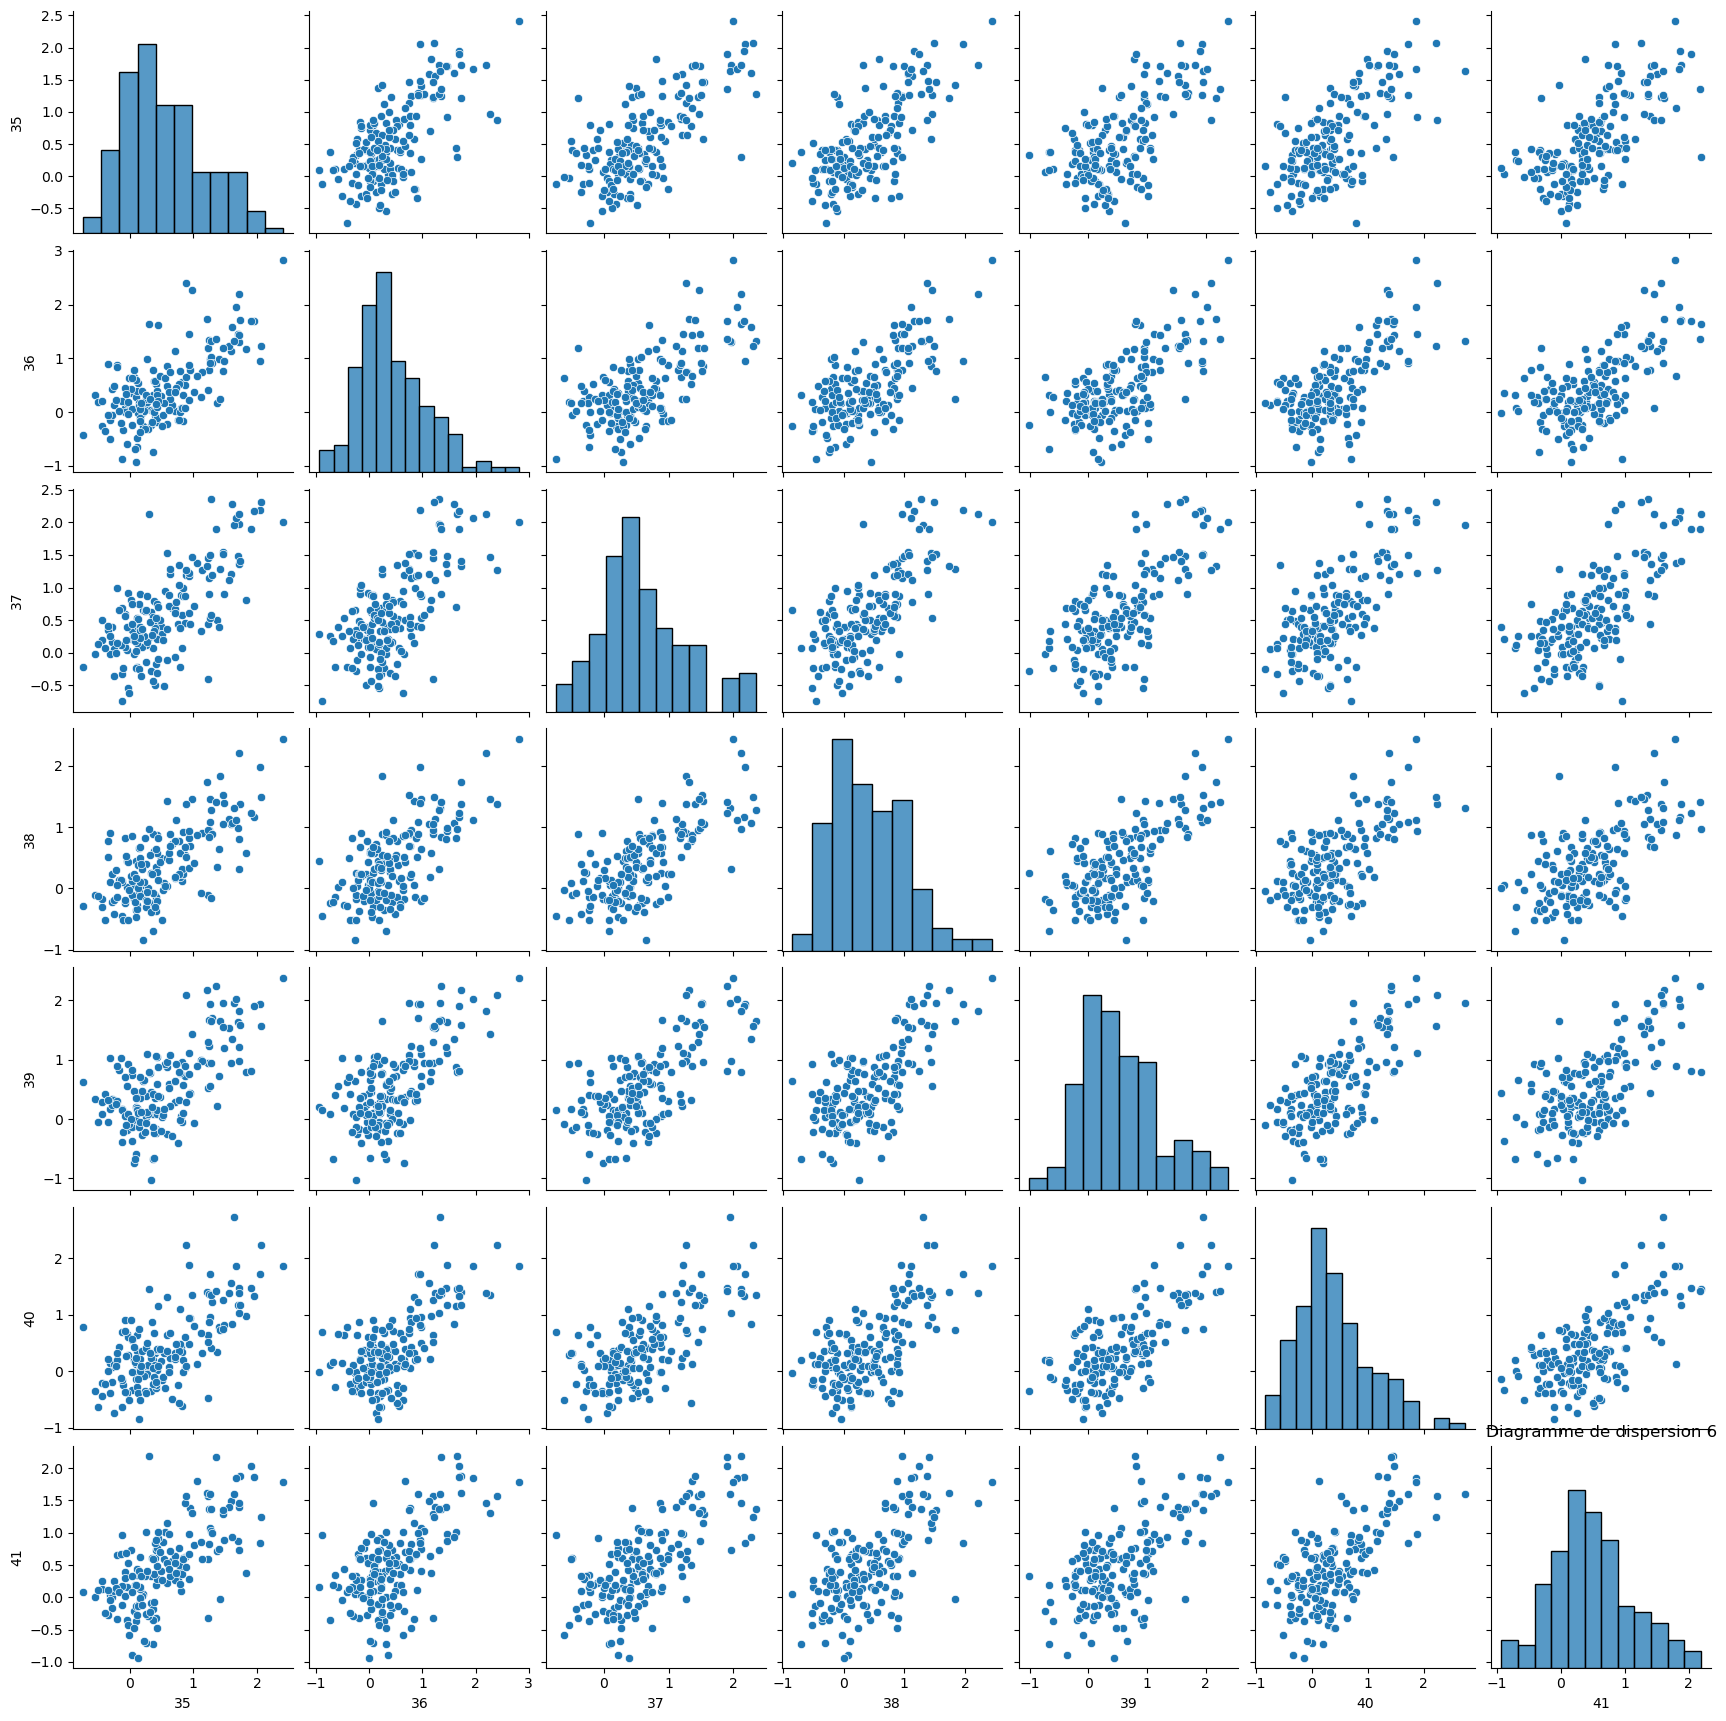

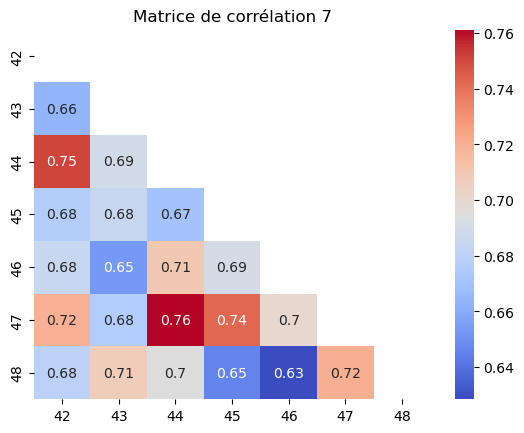

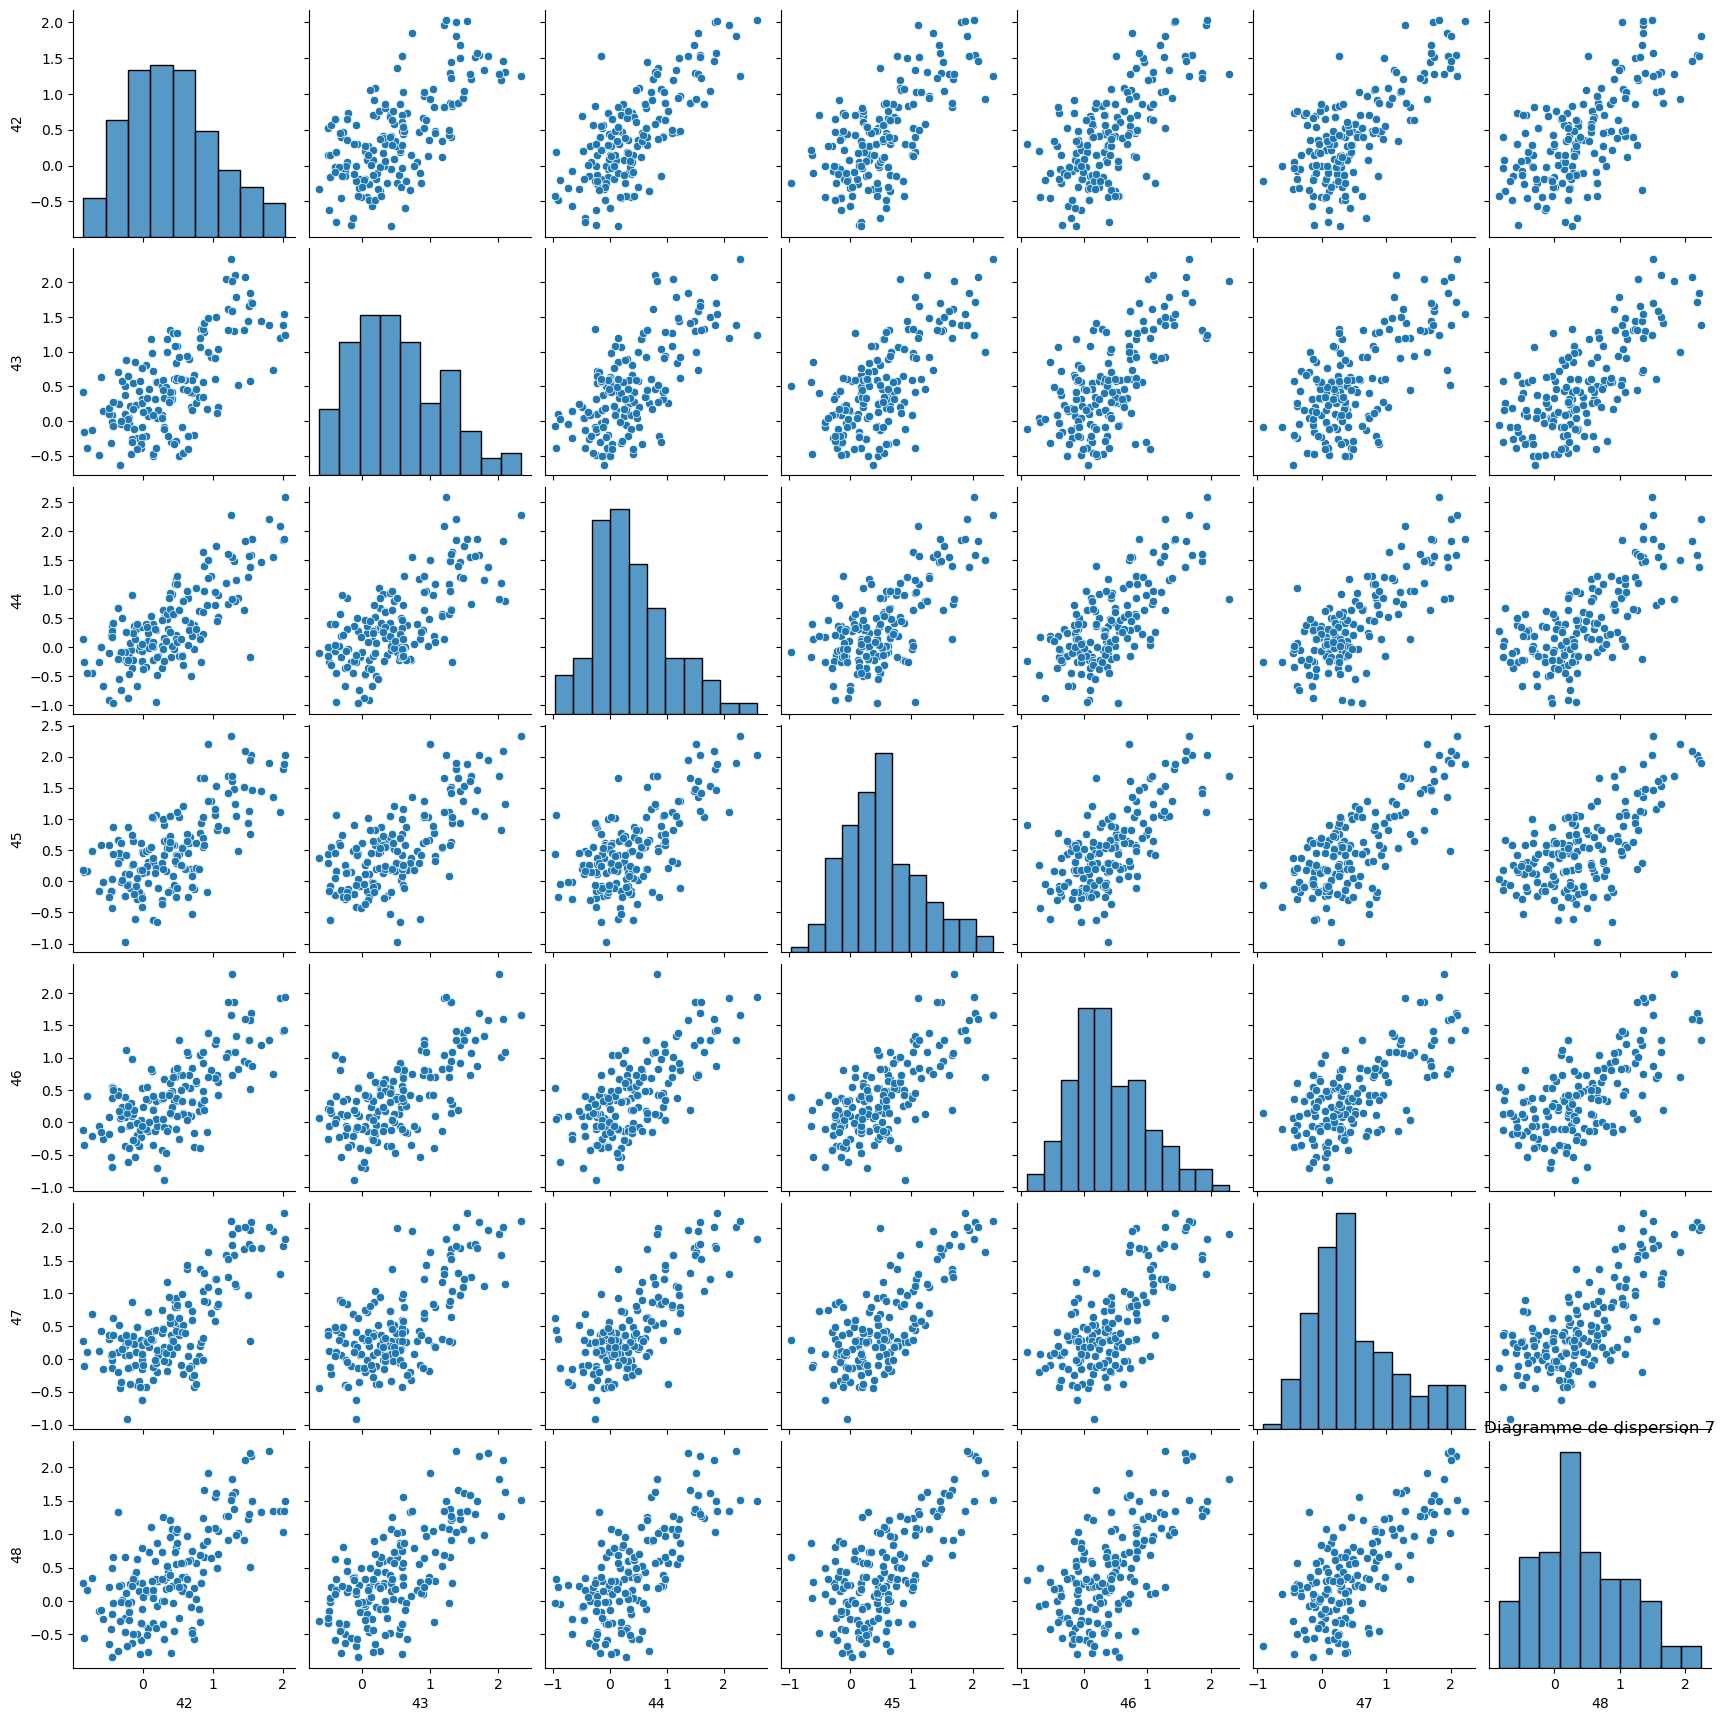

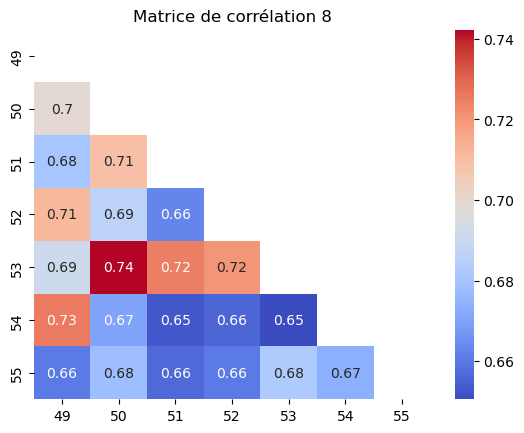

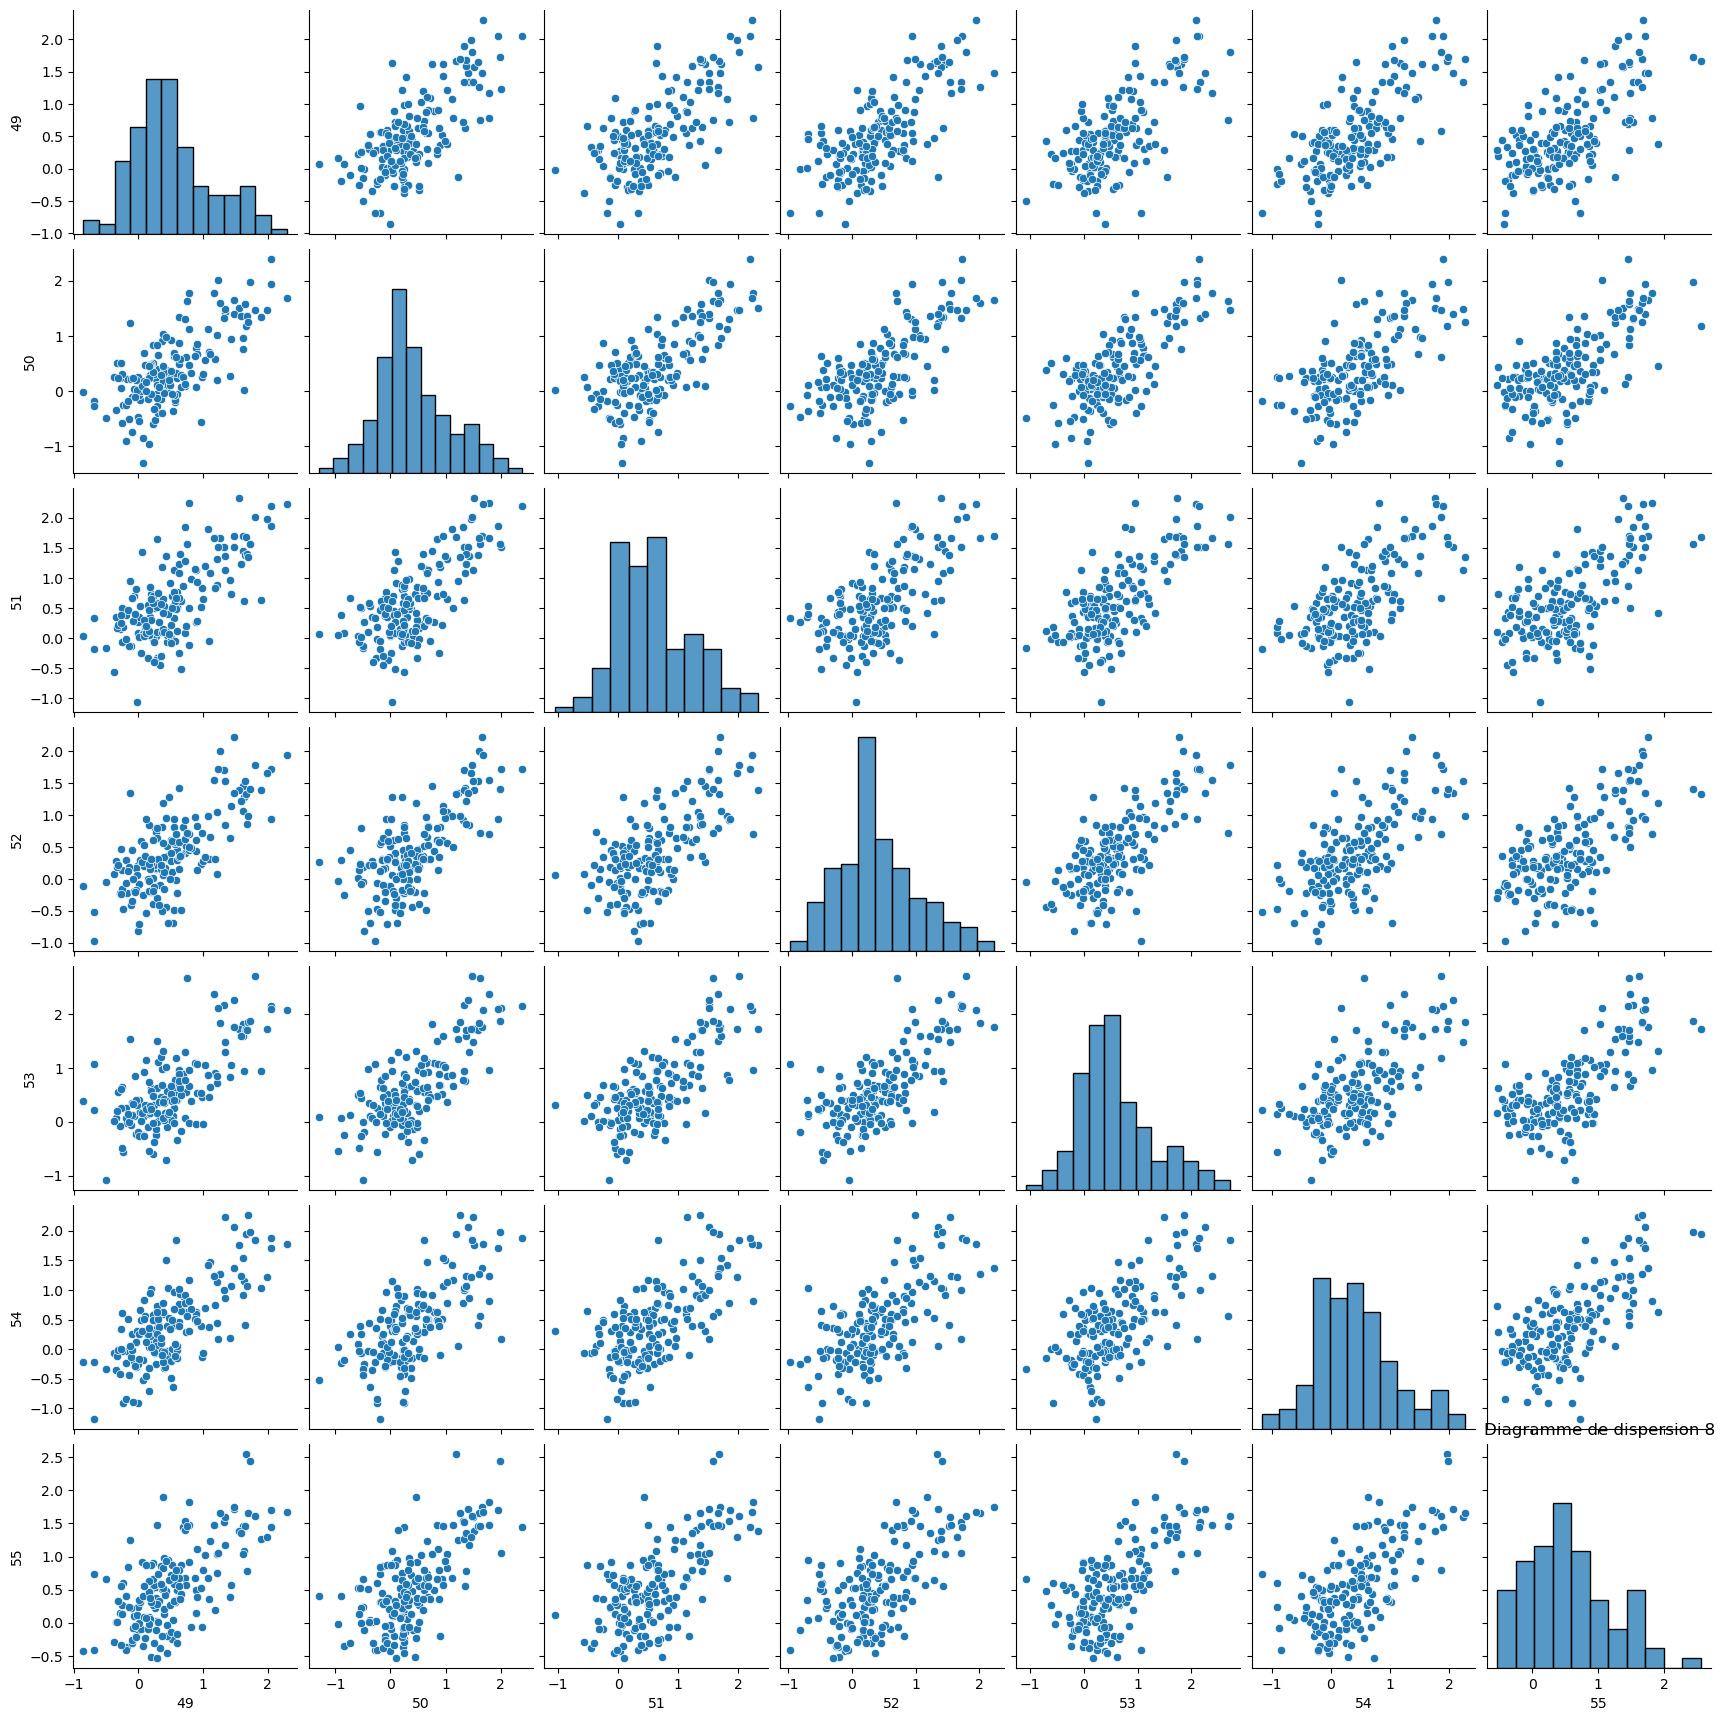

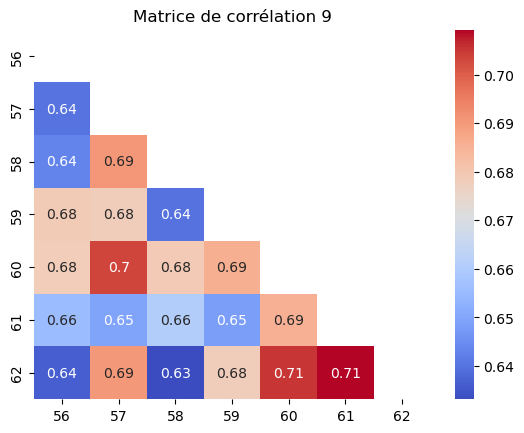

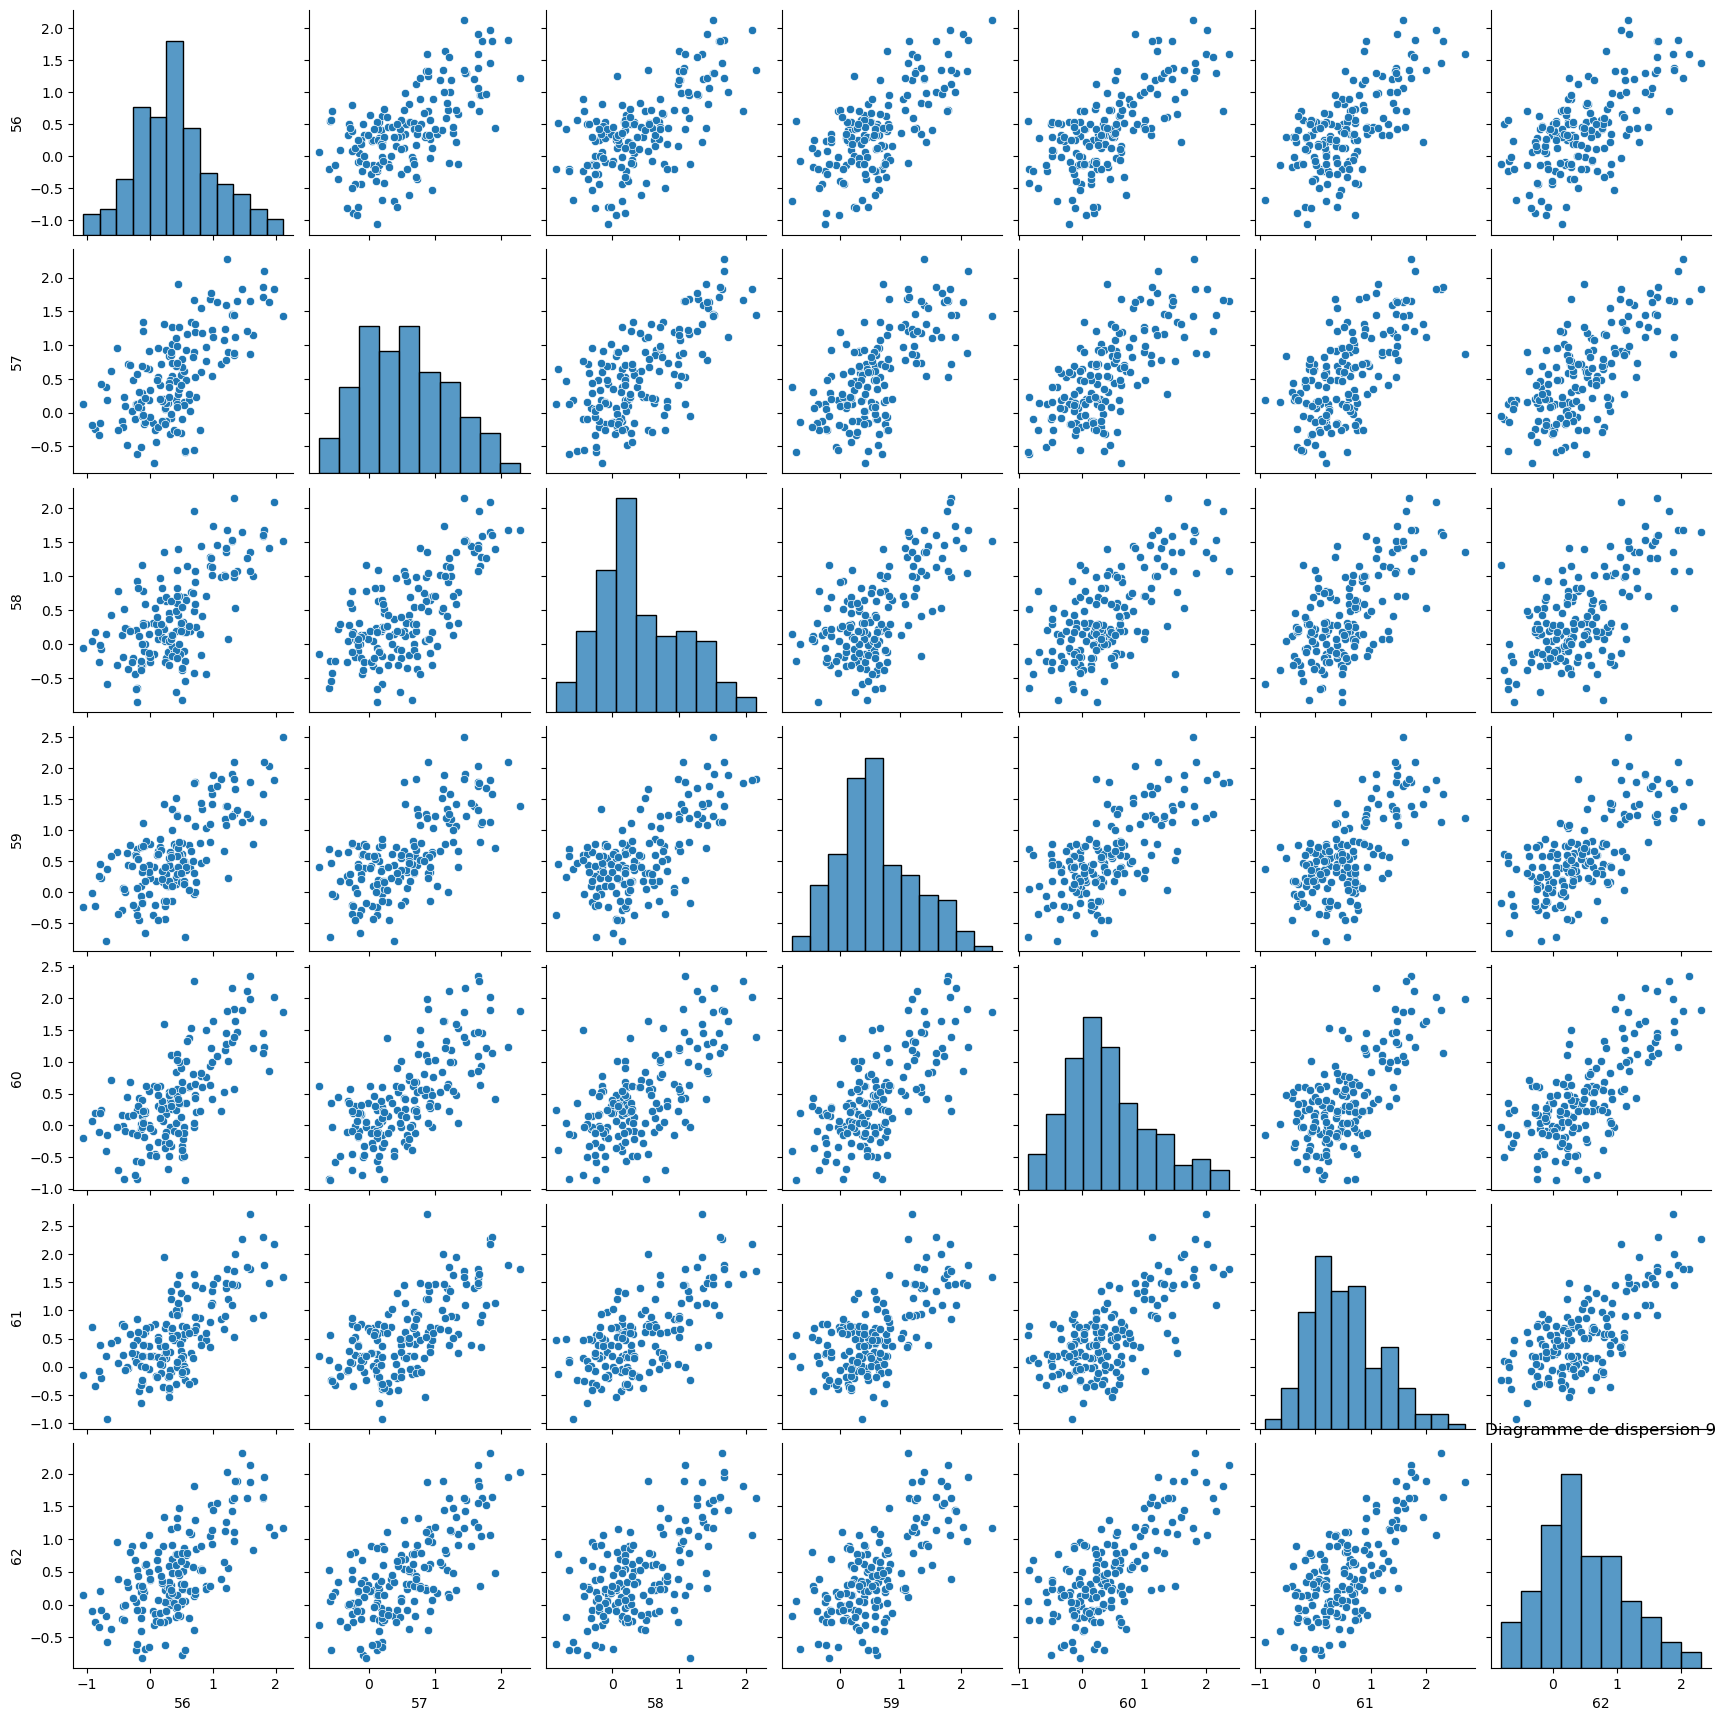

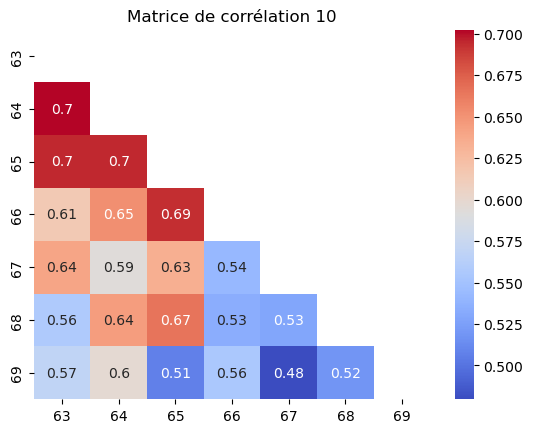

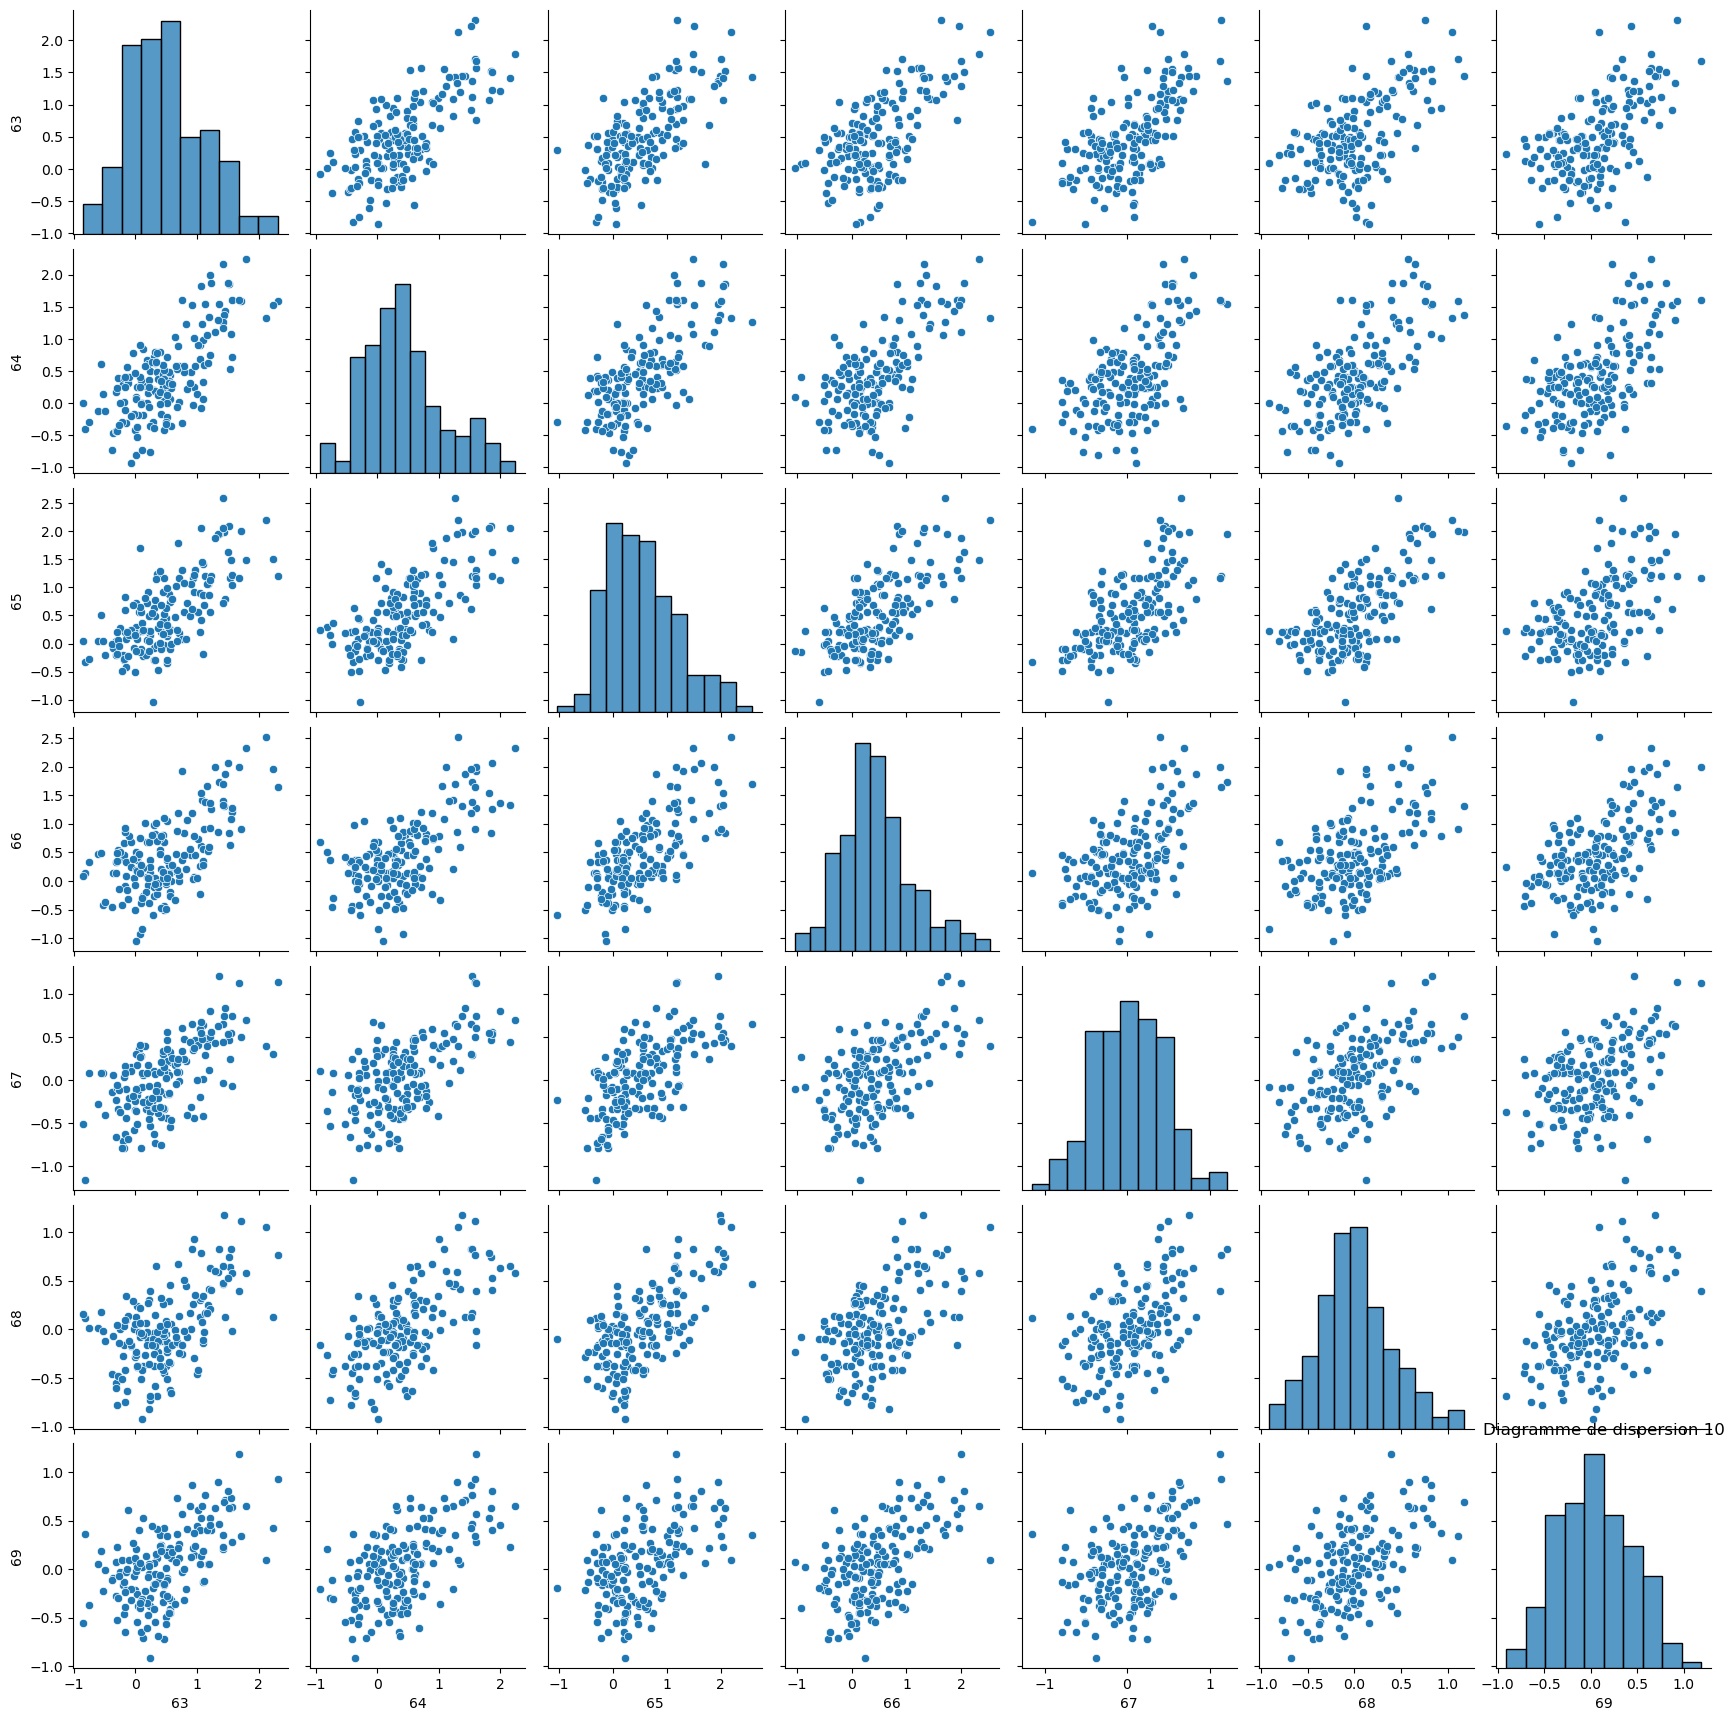

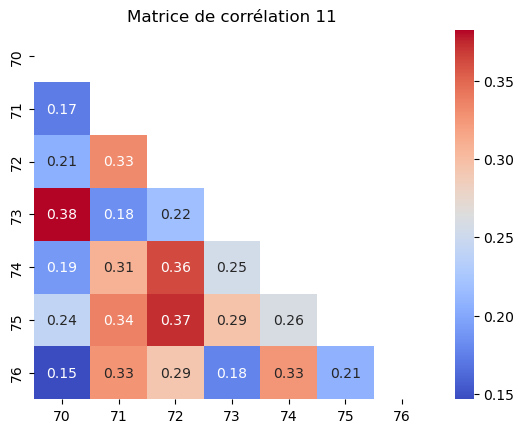

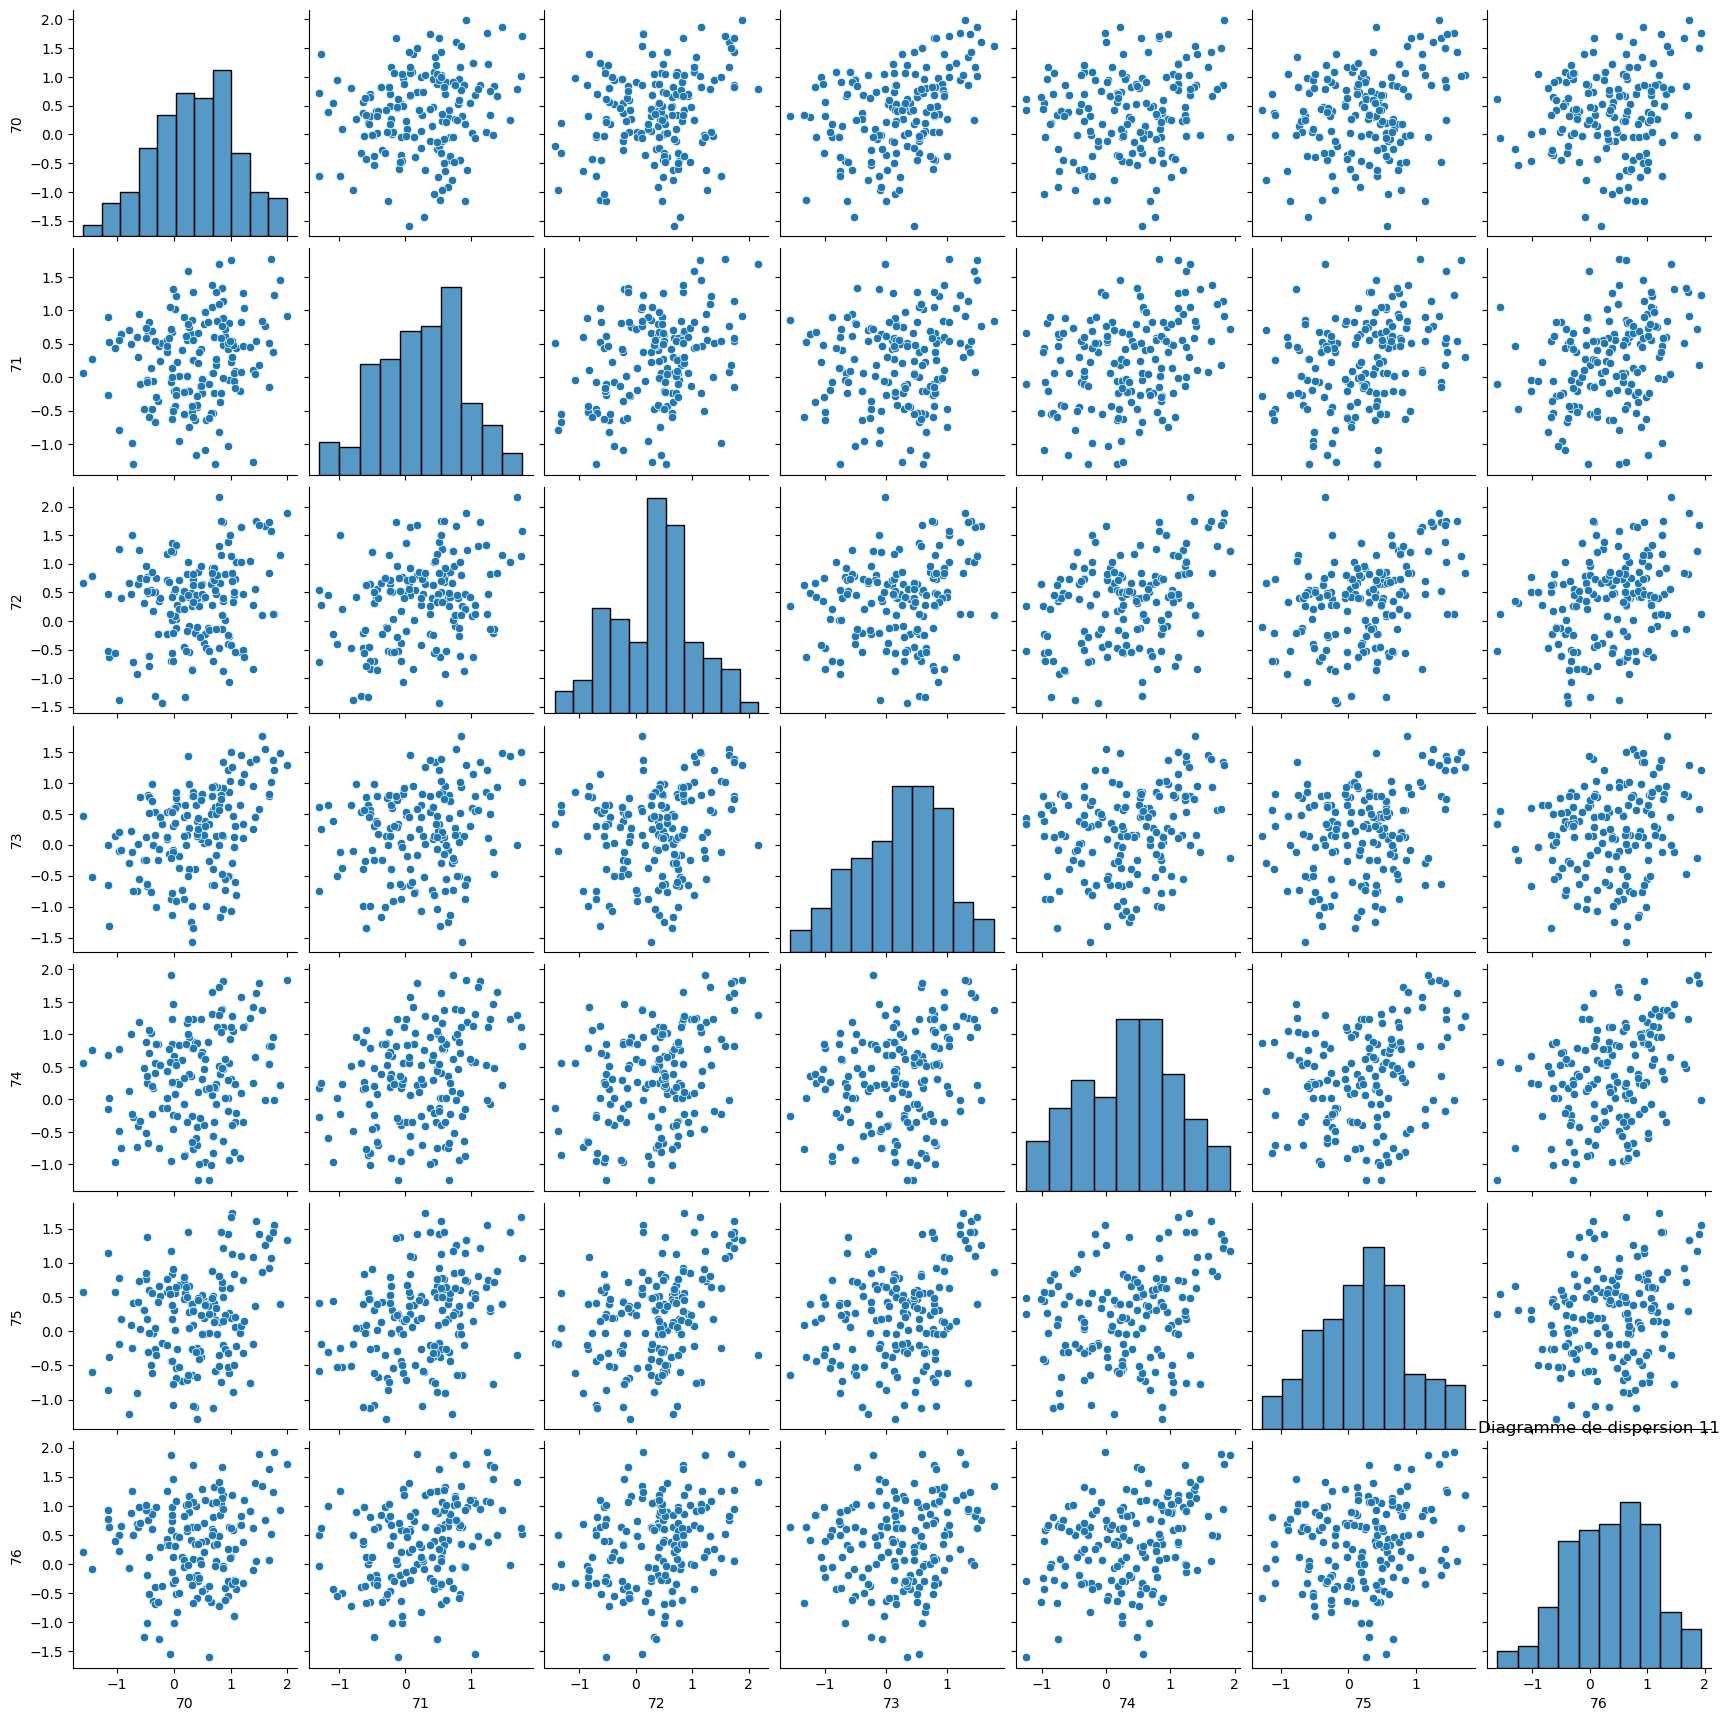

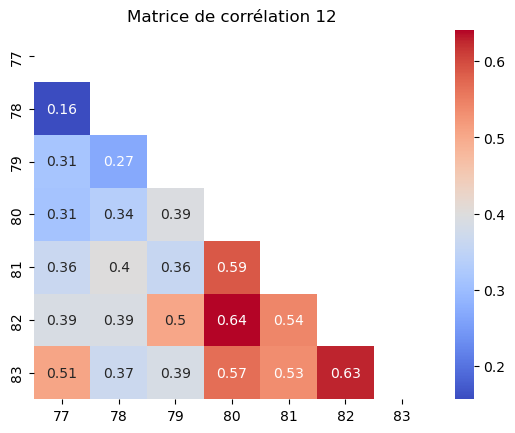

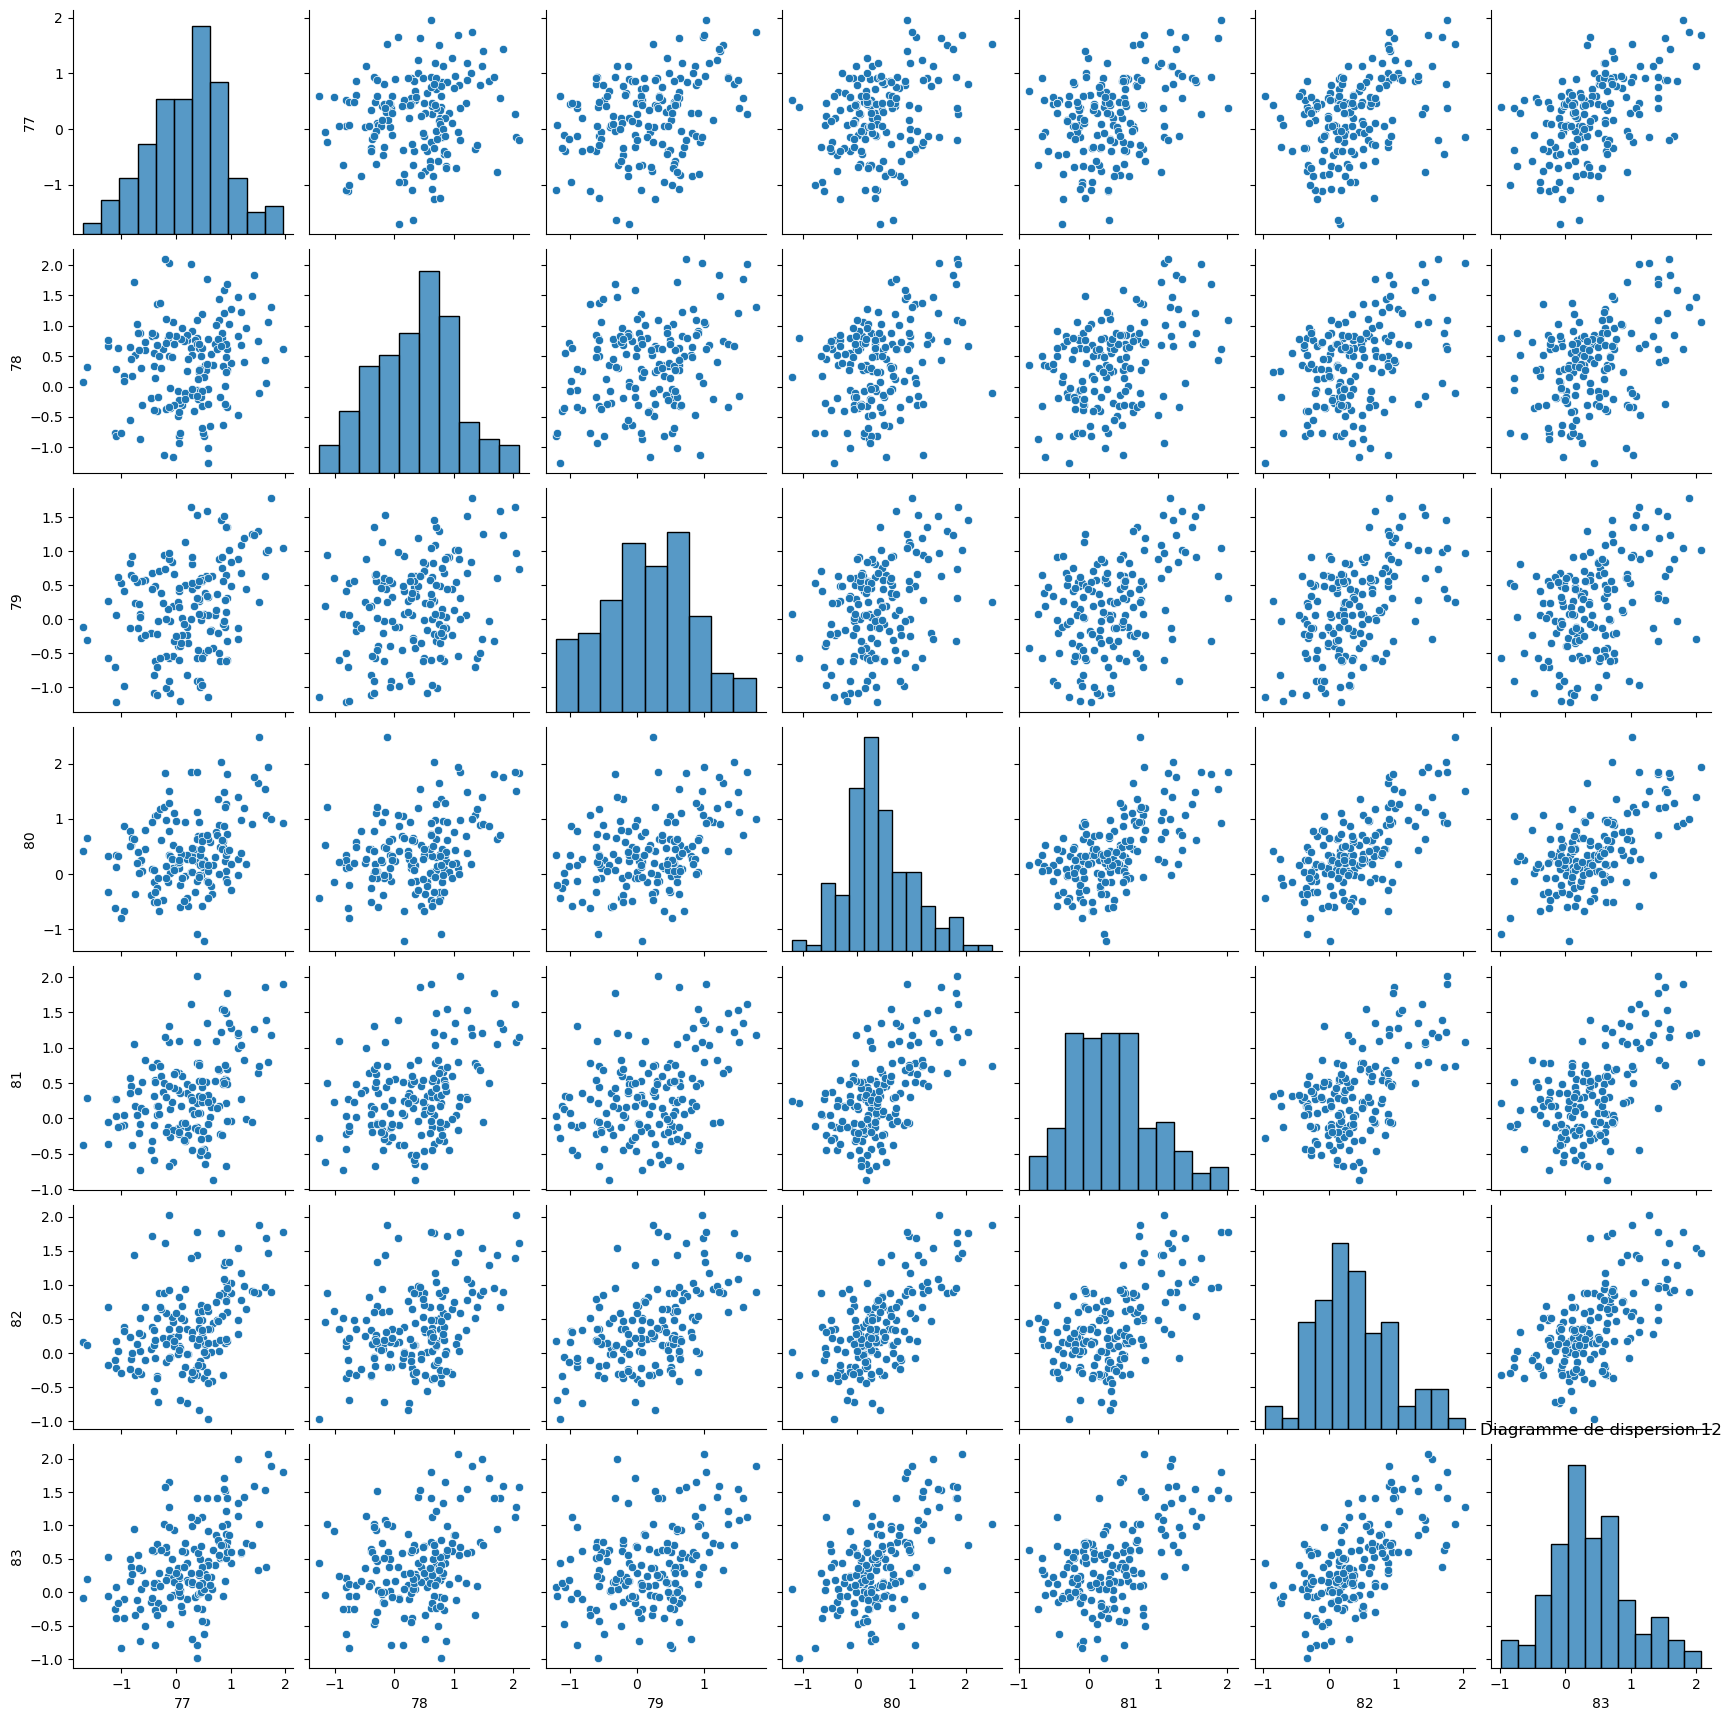

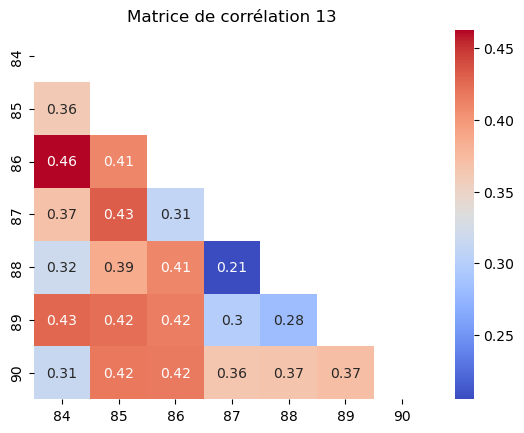

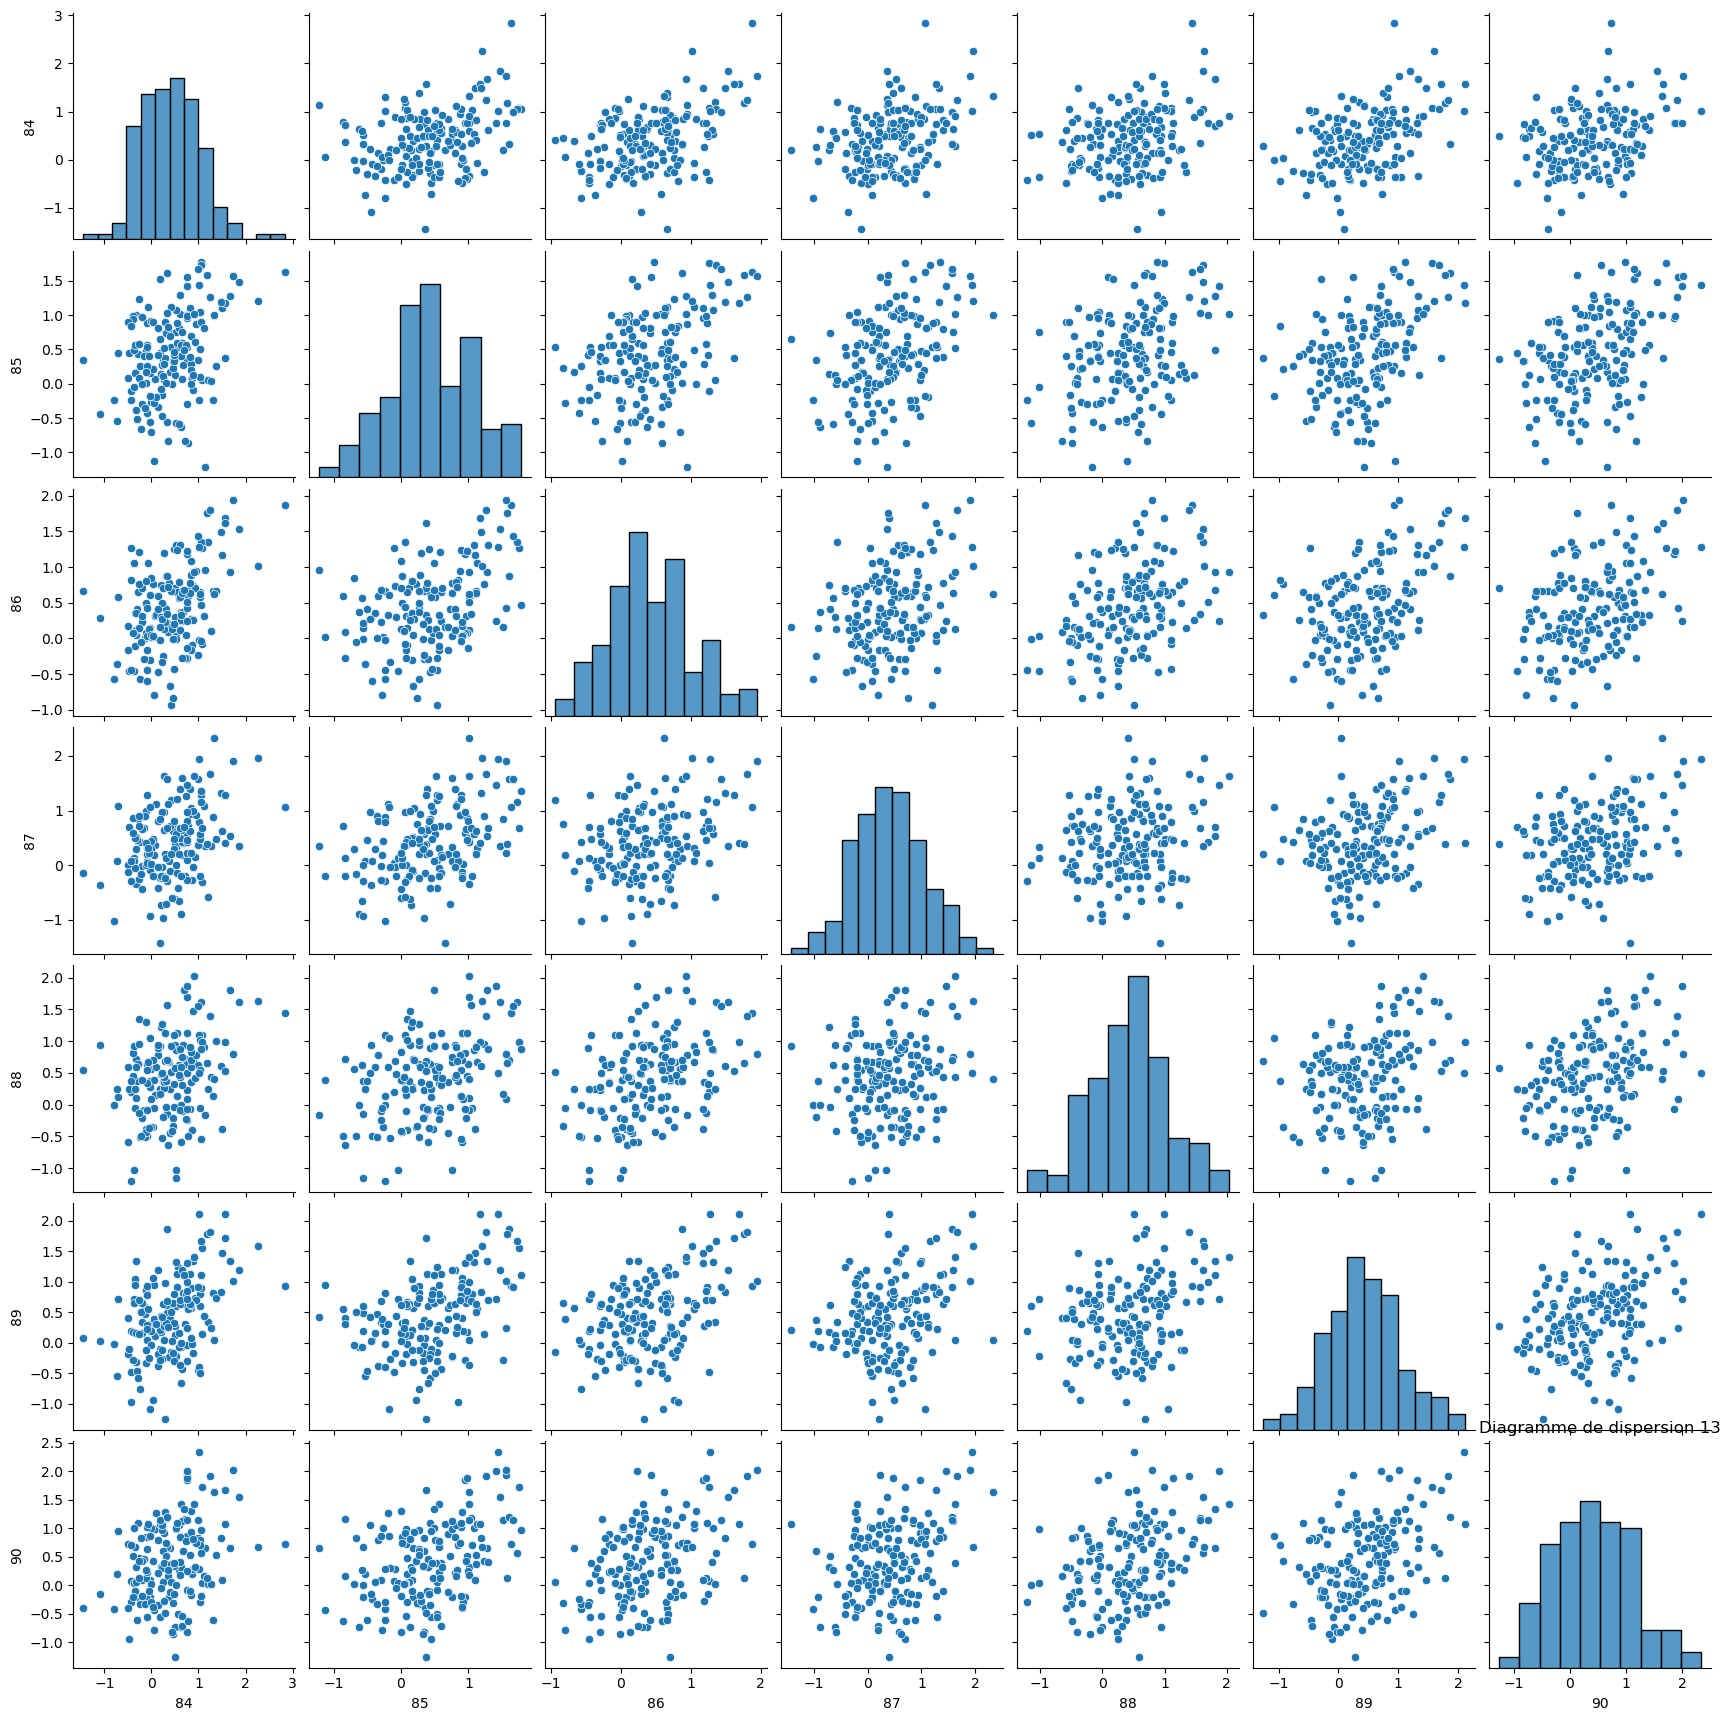

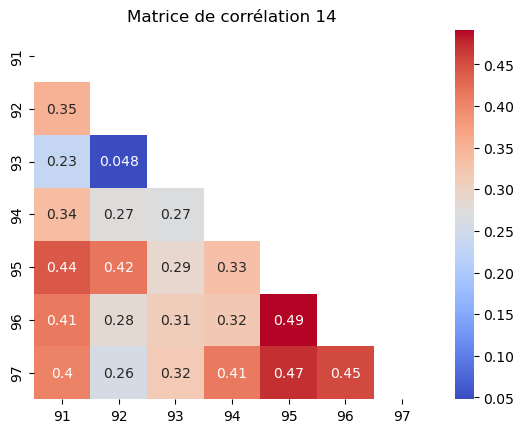

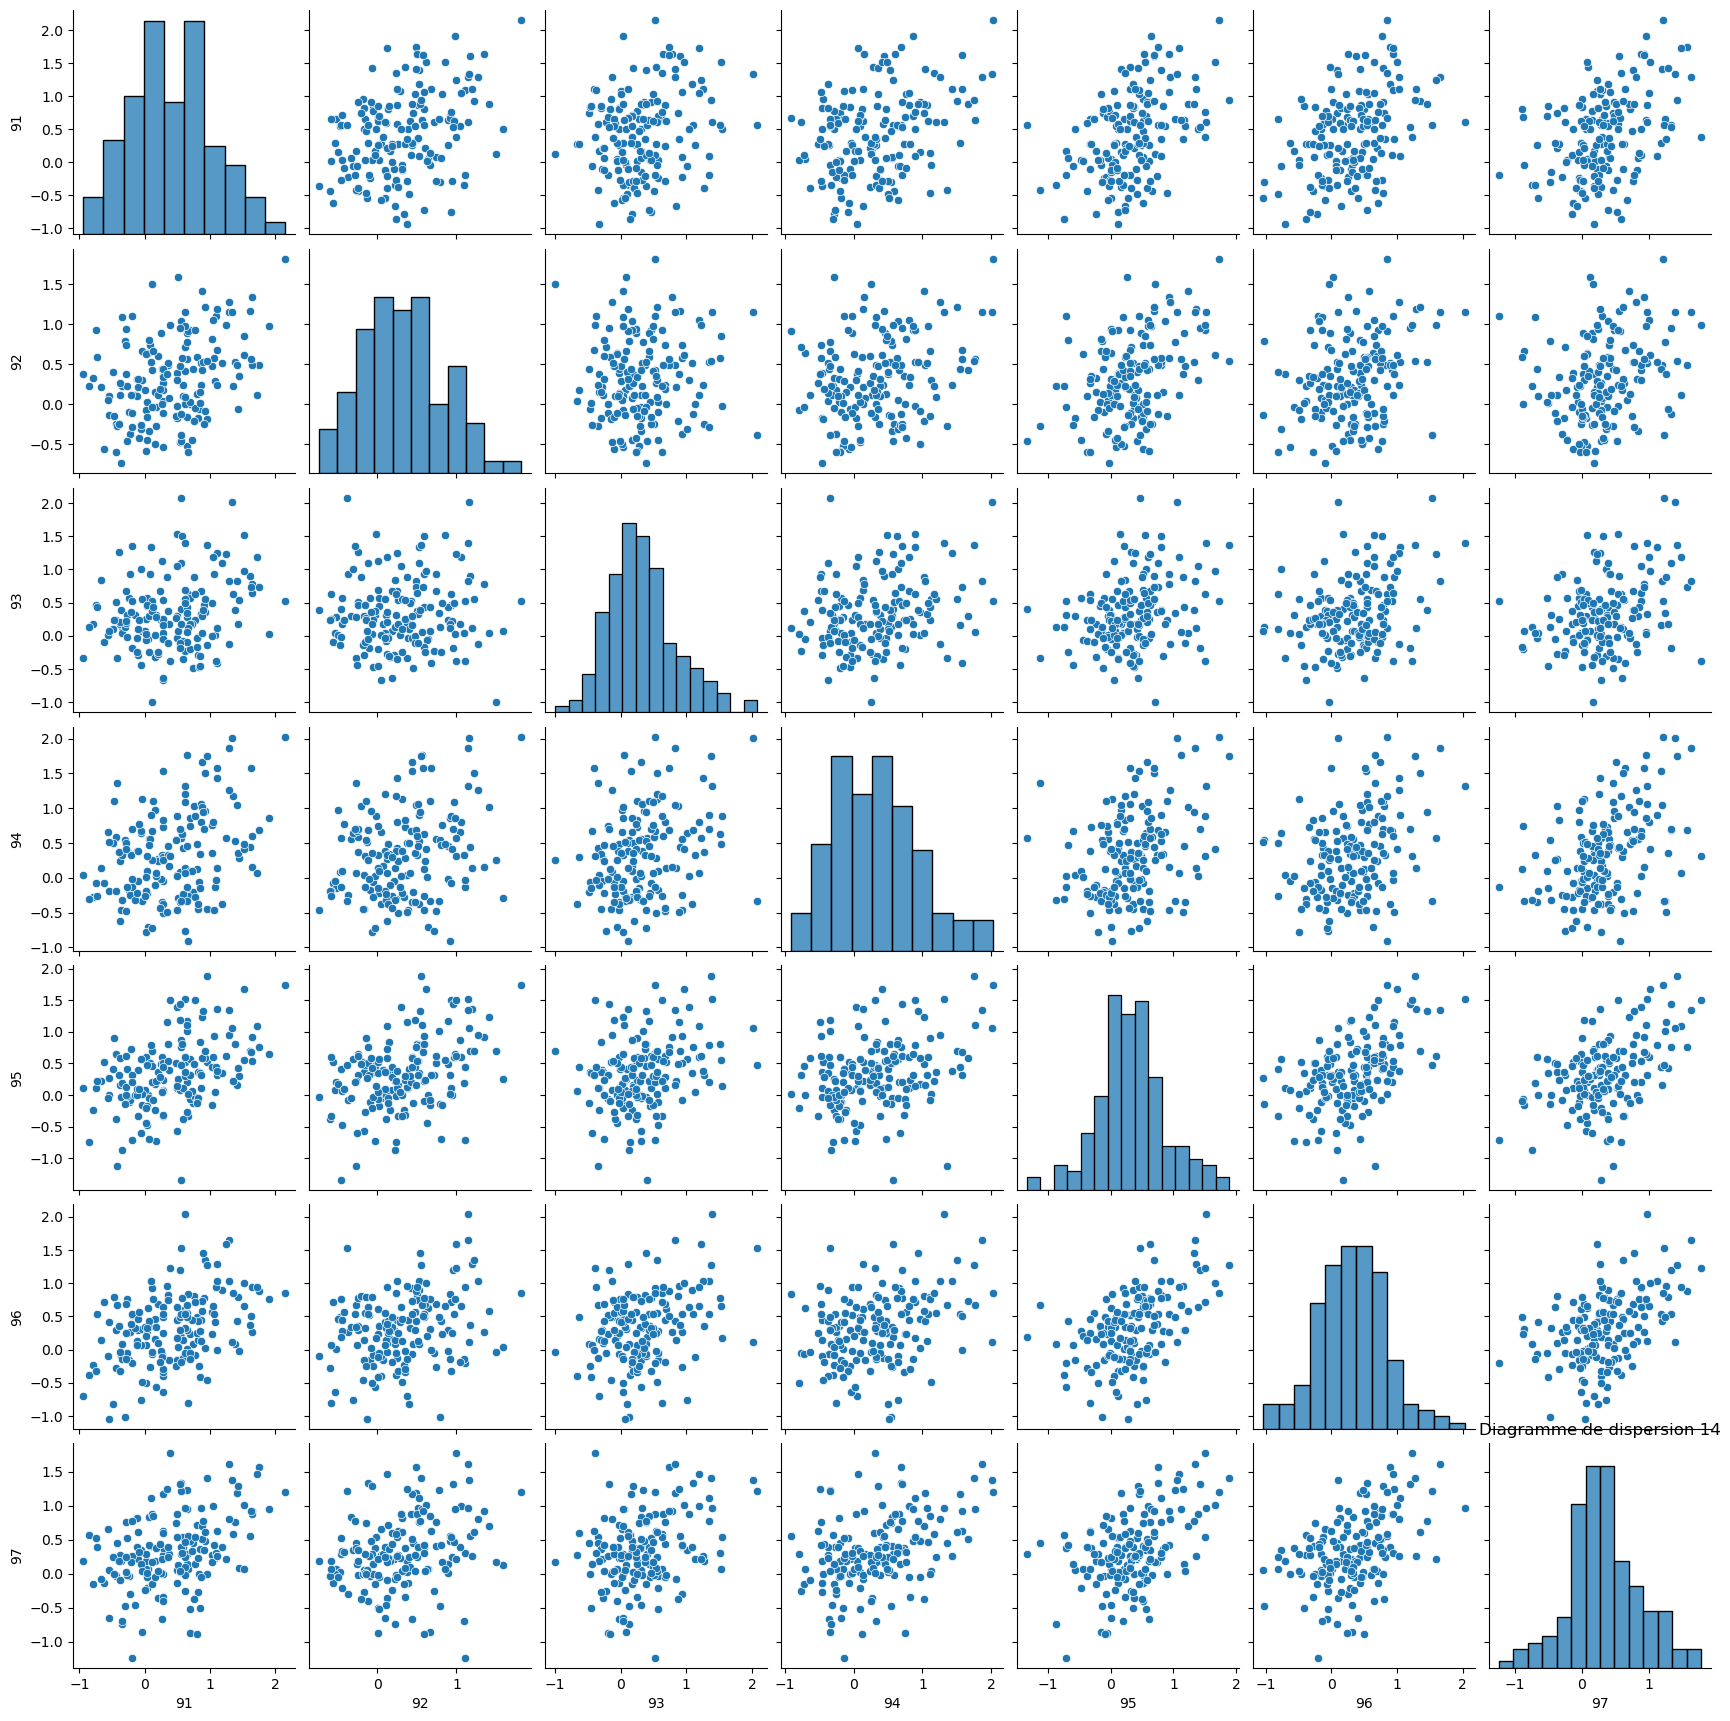

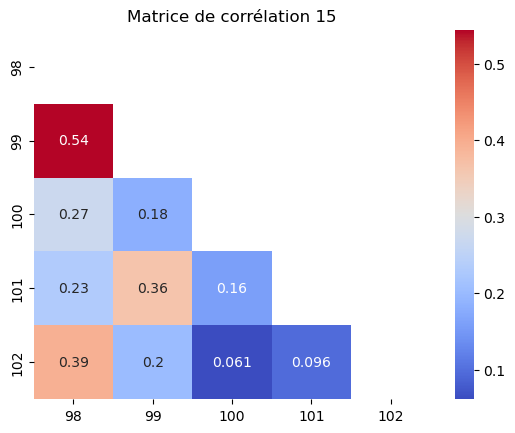

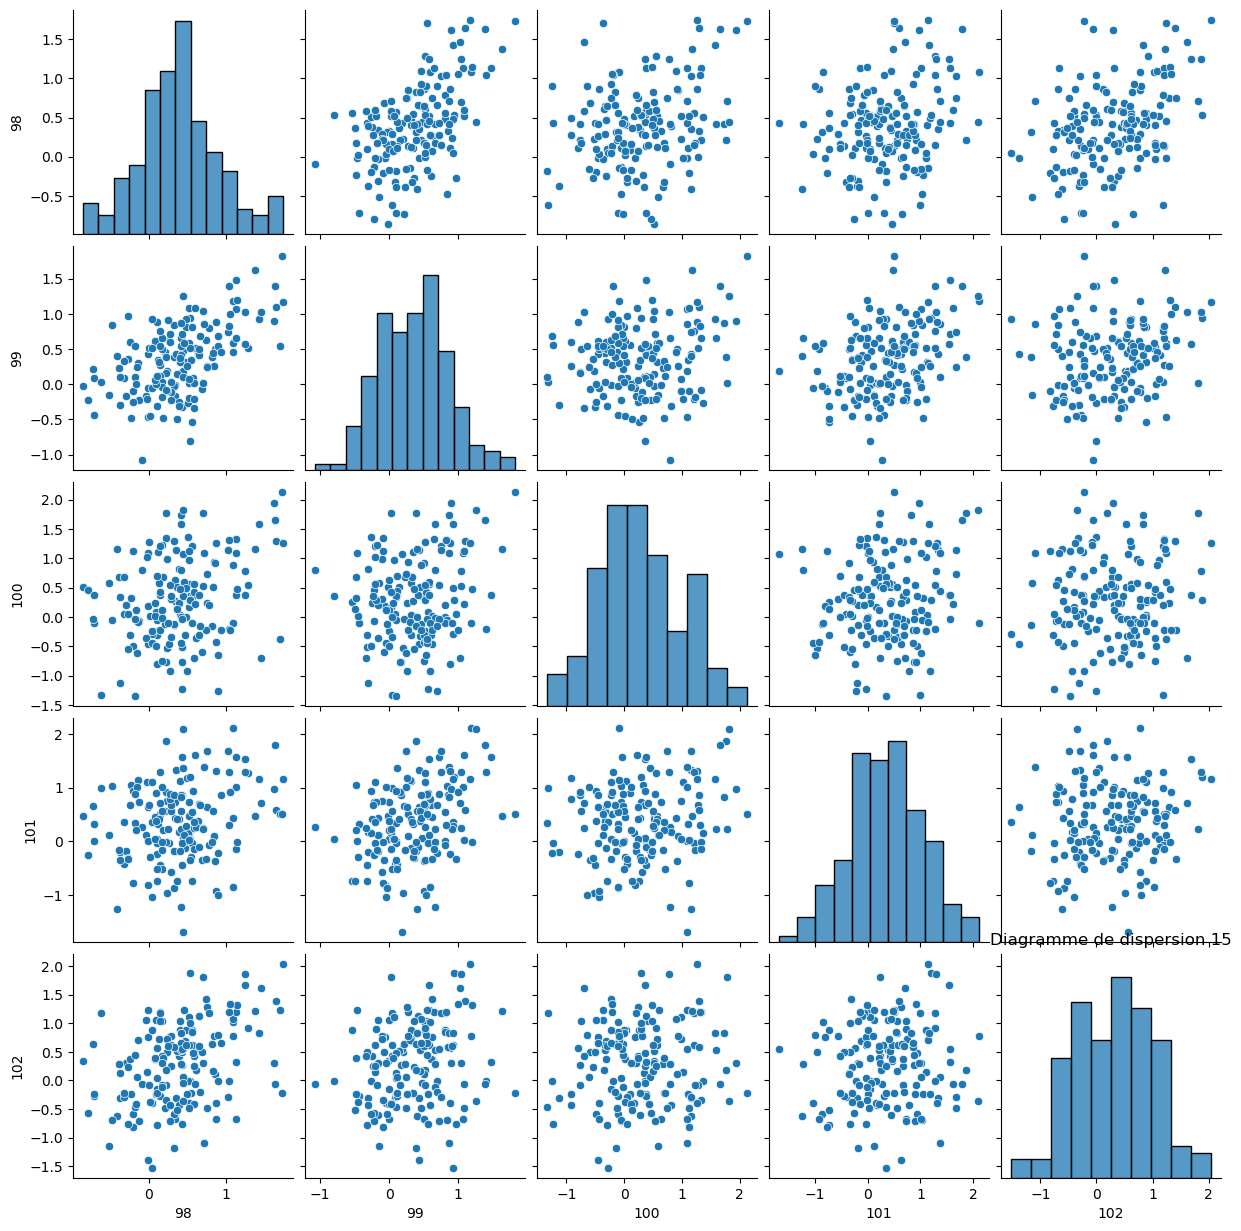

In [42]:
# Charger le fichier CSV
df = pd.read_csv('/Users/dahmani/Desktop/GitPL/Out-My-nb-1/region48/hist-GHG_48.csv')

# Supprimer les deux premières colonnes
df = df.iloc[:, 2:]
df=  df.T
# Diviser les colonnes en sous-ensembles de 20 variables
n_cols = len(df.columns)
subsets = [df.iloc[:, i:i+7] for i in range(0, n_cols, 7)]

# Créer une matrice de corrélation pour chaque sous-ensemble
for i, subset in enumerate(subsets):
    corr_matrix = subset.corr()

    # Masquer les valeurs de corrélation faibles
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True

    # Afficher la matrice de corrélation
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(f'Matrice de corrélation {i+1}')
    plt.show()
    # Afficher le diagramme de dispersion
    sns.pairplot(subset)
    plt.title(f'Diagramme de dispersion {i+1}')
    plt.show()


## Constuire un data set avec les models et les forcages avec le nombre de profils pour chaque cas

* Supprimer les valeurs aberrantes

In [5]:

# chemin du dossier contenant les fichiers .nc
data_dir = '/Users/dahmani/Desktop/GitPL/region{}'.format(region)

# parcours de tous les fichiers .nc dans le dossier
for file_name in os.listdir(data_dir):
    if file_name.endswith('.nc'):
        # ouverture du fichier netcdf avec xarray
        ds = xr.open_dataset(os.path.join(data_dir, file_name))

        # suppression des colonnes contenant des valeurs supérieures à 10
        ds = ds.where((ds <= 20)).drop_vars(ds.coords)

        # remplacement des valeurs NaN par la moyenne des données
        ds = ds.fillna(np.mean(ds))

        # enregistrement du fichier modifié
        ds.to_netcdf(os.path.join(data_dir, file_name))



* Génerer les 3 fichiers, All_sim, models, Forcings

In [34]:


data_dir = '/Users/dahmani/Desktop/stagelong/projetlong/region{}'.format(region)
# Exemple de lecture du forcage GHG ...
#  Lecture des profils d’anomalies de température de l'air, forcage GHG, pour tous les modeles
all_models=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                             'NorESM2-LM']
all_forcings = ['GHG', 'AER', 'NAT', 'HIST']
all_forc_file_ext = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

results_dict = {}

for model_name in all_models:
    model_dict = {}
    for forcing, forc_in_fname in zip(all_forcings, all_forc_file_ext):
        forcings_filename = f'{model_name}_{forc_in_fname}_Reg_region{region}.nc'
        
        profilsT_ds = xr.open_dataset(os.path.join(data_dir, forcings_filename))
        
        # comment savoir quelles variables de données dans le Dataset ?
        # c'est aussi la liste de membres du même forcage pour le modele en question
        list_nc_var = list(profilsT_ds.keys())

        model_dict[forcing] = len(list_nc_var)
        
        #del(profilsT_ds)
    results_dict[model_name] = model_dict

df = pd.DataFrame(results_dict)

All_sim=df.values
models=df.columns
forcings=df.index

# Chemin de sortie pour les fichiers
out_dir = '/Users/dahmani/Desktop/stagelong/projetlong/data_source_dr/Region{}'.format(region)

# Enregistrer All_sim_z48v0 comme fichier .p
with open(os.path.join(out_dir, "All_sim_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(All_sim, f)

# Enregistrer models_z48v0 comme fichier .p
with open(os.path.join(out_dir, "models_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(models.tolist(), f)

# Enregistrer forcings_z48v0 comme fichier .p
with open(os.path.join(out_dir, "forcings_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(forcings.tolist(), f)

#### Générer les 4 fichiers pour chaque forcage 

In [7]:

# Chemin d'accès vers les fichiers NetCDF
chemin_dacces = "/Users/dahmani/Desktop/stagelong/projetlong/region{}/*.nc".format(region)

# Liste des types de forçage
types_forçage = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

# Liste des noms de modèles
noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM']

# Boucle pour parcourir tous les types de forçage
for forçage in types_forçage:
    # Dictionnaire pour stocker les dataframes pour chaque modèle
    df_dict = {}

    # Boucle pour parcourir tous les fichiers NetCDF correspondant au type de forçage
    for fichier in glob.glob(f"/Users/dahmani/Desktop/GitPL/region{region}/*_{forçage}_*_*.nc"):
        # Extraire le nom du modèle à partir du nom de fichier
        modele = [nom_modele for nom_modele in noms_modeles if nom_modele in fichier][0]

        # Vérifier si le modèle existe déjà dans le dictionnaire
        if modele not in df_dict:
            # Si le modèle n'existe pas, créer un nouveau dataframe
            df_dict[modele] = pd.DataFrame()

        # Ouvrir le fichier NetCDF et extraire les données
        ds = xr.open_dataset(fichier)
        df = ds.to_dataframe().reset_index()
        # print(df.iloc[:, :5].columns.values.tolist())
        df = df.loc[:,(list(ds.keys()))]
        df = df.transpose().reset_index().rename(columns={'index': 'Variable'})
        # Ajouter les données au dataframe correspondant
        df['modele'] = modele
        df_dict[modele] = pd.concat([df_dict[modele], df])

    # Vérifier si au moins un modèle a été traité pour le type de forçage
    if df_dict:
        # Vérifier si chaque dataframe pour le modèle contient des données
        df_dict_filtered = {k: v for k, v in df_dict.items() if not v.empty}
#       Trier les dataframes de chaque modèle en fonction de l'ordre des modèles
        df_dict_sorted = {modele: df_dict_filtered[modele] for modele in noms_modeles if modele in df_dict_filtered}
        # Concaténer les dataframes de tous les modèles pour le type de forçage
        df_concat = pd.concat(df_dict_sorted.values())
        # Add the 'modele' column as the first column
        df_concat.insert(0, 'modele', df_concat.pop('modele'))    
        # Écrire le dataframe dans un fichier CSV
        fichier_sortie = f"{forçage}_{region}.csv"
        df_concat.to_csv(fichier_sortie, index=False)

        print(f"Données pour le type de forçage {forçage}: {df_concat.shape}")
    else:
        # Afficher un message d'avertissement si aucun modèle n'a été trouvé pour le type de forçage
        print(f"Aucun modèle trouvé pour le type de forçage {forçage}")

Données pour le type de forçage hist-GHG: (103, 167)
Données pour le type de forçage hist-aer: (89, 167)
Données pour le type de forçage hist-nat: (160, 167)
Données pour le type de forçage historical: (256, 167)


In [37]:


# lire les fichiers csv en tant que dataframe
hist_GHG = pd.read_csv('hist-GHG_{}.csv'.format(region))
hist_aer = pd.read_csv('hist-aer_{}.csv'.format(region))
hist_nat = pd.read_csv('hist-nat_{}.csv'.format(region))
historical = pd.read_csv('historical_{}.csv'.format(region))

# supprimer les deux premières colonnes de chaque dataframe
hist_GHG = hist_GHG.iloc[:, 2:]
hist_aer = hist_aer.iloc[:, 2:]
hist_nat = hist_nat.iloc[:, 2:]
historical = historical.iloc[:, 2:]


# convertir chaque dataframe en tableau numpy (array)
hist_GHG = np.array(hist_GHG)
hist_aer = np.array(hist_aer)
hist_nat = np.array(hist_nat)
historical = np.array(historical)

#Lissage 
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)

hist_GHG = signal.filtfilt(b_lp_filter, a_lp_filter, hist_GHG)
hist_aer = signal.filtfilt(b_lp_filter, a_lp_filter, hist_aer)
hist_nat = signal.filtfilt(b_lp_filter, a_lp_filter, hist_nat)
historical = signal.filtfilt(b_lp_filter, a_lp_filter, historical)


# plt.plot(hist_GHG[:,:].T)
# Afficher le nombre de lignes et de colonnes du dataframe

# Définir le chemin où sauvegarder les fichiers .p
output_path = "/Users/dahmani/Desktop/stagelong/projetlong/data_source_dr/Region{}".format(region)

# Sauvegarder chaque tableau numpy en tant que fichier .p
with open(os.path.join(output_path, 'T_ghg_z{}v0.p'.format(region)), 'wb') as f:
    pickle.dump(hist_GHG, f)
with open(os.path.join(output_path, 'T_aer_z{}v0.p'.format(region)), 'wb') as f:
    pickle.dump(hist_aer, f)
with open(os.path.join(output_path, 'T_nat_z{}v0.p'.format(region)), 'wb') as f:
    pickle.dump(hist_nat, f)
with open(os.path.join(output_path, 'T_hist_z{}v0.p'.format(region)), 'wb') as f:
    pickle.dump(historical, f)



* Tester les données si cava

In [24]:
test1=pd.read_csv("/Users/dahmani/Desktop/stagelong/projetlong/Code-PL/hist-nat_48.csv")


In [26]:
df=test1[test1.modele.str.contains("MIROC6")]
df


modele           Variable         0         1         2         3  \
102  MIROC6  tas_r10i1p1f1_ano  0.368683  1.304867  0.238862 -0.924709   
103  MIROC6  tas_r11i1p1f1_ano  0.347013 -0.836082 -0.806265 -0.244760   
104  MIROC6  tas_r12i1p1f1_ano -0.381859  0.195356  0.352013  0.383775   
105  MIROC6  tas_r13i1p1f1_ano -0.016979  0.465787  0.227786  0.340703   
106  MIROC6  tas_r14i1p1f1_ano  0.316080 -0.141403  0.397321  1.045912   
107  MIROC6  tas_r15i1p1f1_ano  0.195754  0.029440  0.104761 -0.182615   
108  MIROC6  tas_r16i1p1f1_ano -0.045111 -0.252002  0.279980  0.977905   
109  MIROC6  tas_r17i1p1f1_ano -0.777167 -0.295546  0.391918  0.586999   
110  MIROC6  tas_r18i1p1f1_ano  0.168835  0.547379  0.877641  0.754862   
111  MIROC6  tas_r19i1p1f1_ano -0.155130 -0.116652 -0.018237  0.230722   
112  MIROC6   tas_r1i1p1f1_ano -0.080309 -0.039456  0.368110  0.435682   
113  MIROC6  tas_r20i1p1f1_ano  0.187716  0.049906  0.471119  1.040929   
114  MIROC6  tas_r21i1p1f1_ano -0.097298  0.547852  0.586788 -0.739999   
115  MIROC6  tas_r22i1p1f1_ano -0.175527 -0.076727  0.096816  0.026145   
116  MIROC6  tas_r23i1p1f1_ano -0.345460 -0.095381 -0.371153 -0.214509   
117  MIROC6  tas_r24i1p1f1_ano  0.066622 -0.714915  0.063932  0.750569   
118  MIROC6  tas_r25i1p1f1_ano  0.942924  0.437845 -0.471035 -0.042972   
119  MIROC6  tas_r26i1p1f1_ano  0.124140  0.051839 -0.016778  0.300424   
120  MIROC6  tas_r27i1p1f1_ano -0.568808  0.053105  0.132692  0.264904   
121  MIROC6  tas_r28i1p1f1_ano -0.299233  0.220463 -0.085167 -0.103676   
122  MIROC6  tas_r29i1p1f1_ano -0.519606 -0.008777  0.540810  0.513181   
123  MIROC6   tas_r2i1p1f1_ano  0.294030  0.055674 -0.100203  0.042119   
124  MIROC6  tas_r30i1p1f1_ano -0.025802 -0.133857  0.350147  1.022109   
125  MIROC6  tas_r31i1p1f1_ano  1.337983  0.540494 -0.959024 -0.716214   
126  MIROC6  tas_r32i1p1f1_ano -0.135226  0.359275  0.173866 -0.283123   
127  MIROC6  tas_r33i1p1f1_ano  0.289132 -0.177161  0.000784  0.148335   
128  MIROC6  tas_r34i1p1f1_ano  0.237402 -0.181098 -0.006595  0.487169   
129  MIROC6  tas_r35i1p1f1_ano -0.493330  0.211166  0.774040  0.527514   
130  MIROC6  tas_r36i1p1f1_ano  0.466999  0.874508  0.926109  0.002612   
131  MIROC6  tas_r37i1p1f1_ano  0.545412 -0.376126 -0.190898  0.149527   
132  MIROC6  tas_r38i1p1f1_ano -0.118012 -0.335924 -0.295190 -0.026988   
133  MIROC6  tas_r39i1p1f1_ano -0.476786 -0.199481 -0.424040 -0.594829   
134  MIROC6   tas_r3i1p1f1_ano -0.438232  0.021108  0.311072  0.189393   
135  MIROC6  tas_r40i1p1f1_ano  0.190253  0.330985 -0.306098 -0.786679   
136  MIROC6  tas_r41i1p1f1_ano -0.006182 -0.114217  0.017132  0.421197   
137  MIROC6  tas_r42i1p1f1_ano  1.329600  0.462660 -0.990916 -0.714524   
138  MIROC6  tas_r43i1p1f1_ano  0.450184 -0.573094 -0.511825  0.019458   
139  MIROC6  tas_r44i1p1f1_ano -0.830418 -0.201790  0.429865  0.160845   
140  MIROC6  tas_r45i1p1f1_ano -0.044325  0.213716  0.339385  0.184735   
141  MIROC6  tas_r46i1p1f1_ano -0.288443 -0.031986  0.249192  1.149875   
142  MIROC6  tas_r47i1p1f1_ano -0.205883 -0.064460  0.287275  0.799106   
143  MIROC6  tas_r48i1p1f1_ano -0.668628 -0.464764  0.711162  1.051387   
144  MIROC6  tas_r49i1p1f1_ano  0.941885  0.718581 -0.184250 -0.346319   
145  MIROC6   tas_r4i1p1f1_ano  1.230066  0.382888 -0.975684 -0.531524   
146  MIROC6  tas_r50i1p1f1_ano  0.174062 -0.059194  0.186425  0.817185   
147  MIROC6   tas_r5i1p1f1_ano  0.961370  0.297159 -0.450815 -0.412080   
148  MIROC6   tas_r6i1p1f1_ano -0.504811 -0.667909  0.470264  0.029243   
149  MIROC6   tas_r7i1p1f1_ano -0.769272 -0.624045 -0.199416  0.492953   
150  MIROC6   tas_r8i1p1f1_ano -0.319038  0.019678  0.436923  0.976466   
151  MIROC6   tas_r9i1p1f1_ano -0.383213 -0.439782 -0.222431 -0.558563   

            4         5         6         7  ...       155       156  \
102 -0.393633 -0.184284 -0.132564  0.153411  ... -0.084256  0.285887   
103  0.300581  1.022799 -0.135230 -0.677223  ... -0.670174 -0.148444   
104  0.487239 

In [27]:
df.describe()

0          1          2          3          4          5  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    0.039921   0.023398   0.064163   0.177997   0.151292   0.059702   
std     0.531875   0.417907   0.456114   0.558525   0.408873   0.558565   
min    -0.830418  -0.836082  -0.990916  -0.924709  -0.463983  -1.093693   
25%    -0.338854  -0.194885  -0.197287  -0.206536  -0.161727  -0.293237   
50%    -0.035064  -0.020381   0.118726   0.172790   0.143321   0.037362   
75%     0.292806   0.277985   0.364085   0.523931   0.305953   0.394056   
max     1.337983   1.304867   0.926109   1.149875   1.171089   1.407290   

               6          7          8          9  ...        155        156  \
count  50.000000  50.000000  50.000000  50.000000  ...  50.000000  50.000000   
mean    0.001302  -0.032725   0.016330   0.115256  ...   0.028497   0.025978   
std     0.464938   0.433166   0.488563   0.393025  ...   0.461443   0.431878   
min    -0.796490  -0.911280  -1.207842  -0.634310  ...  -1.141505  -0.734551   
25%    -0.295217  -0.286198  -0.238517  -0.152265  ...  -0.275260  -0.261965   
50%    -0.049906  -0.064573   0.100341   0.164045  ...   0.042549   0.009851   
75%     0.292064   0.285019   0.334306   0.314528  ...   0.211785   0.182775   
max     1.176630   1.128566   0.966285   0.974205  ...   1.282111   1.442584   

             157        158        159        160        161        162  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    0.041705   0.110573   0.170582   0.124806   0.078406   0.121572   
std     0.396893   0.417807   0.458916   0.480606   0.514293   0.397738   
min    -0.786216  -0.710486  -0.818832  -1.082522  -0.744187  -0.641459   
25%    -0.222398  -0.136639  -0.102817  -0.147969  -0.282876  -0.142782   
50%     0.068073   0.047538   0.050841   0.071368   0.044325   0.104553   
75%     0.250893   0.368916   0.543019   0.378514   0.344215   0.318769   
max     1.070122   1.192191   1.083077   1.406937   1.397294   1.017237   

             163        164  
count  50.000000  50.000000  
mean    0.031993   0.122814  
std     0.475753   0.448989  
min    -1.037925  -0.758086  
25%    -0.203858  -0.150342  
50%     0.082026   0.071210  
75%     0.321726   0.359853  
max     1.245918   0.985962  

[8 rows x 165 columns]

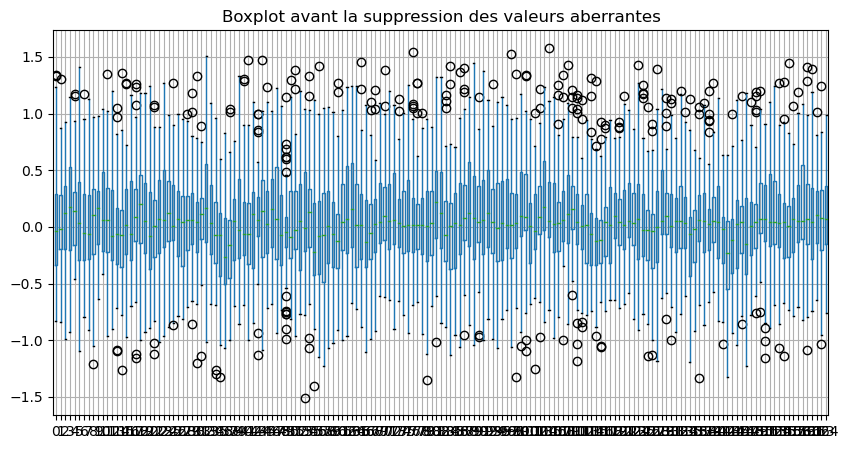

In [28]:
# Visualiser le boxplot avant la suppression des valeurs aberrantes
plt.figure(figsize=(10, 5))
plt.title("Boxplot Aprés la suppression des valeurs aberrantes")
df.boxplot()
plt.show()


In [22]:
df=df.drop(columns=["modele","Variable"]).values

In [ ]:
# # Visualiser le boxplot avant la suppression des valeurs aberrantes
# plt.figure(figsize=(10, 5))
# plt.title("Boxplot avant la suppression des valeurs aberrantes")
# df.boxplot()
# plt.show()

# # Identifier les valeurs aberrantes avec l'écart interquartile (IQR)
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1
# aberrant = ((df < (Q1 - 1.8 * IQR)) | (df > (Q3 + 1.8 * IQR))).any(axis=1)

# # Supprimer les lignes contenant des valeurs aberrantes
# df_clean = df[~aberrant]
# # Afficher le nombre de lignes supprimées
# print("Nombre de lignes supprimées : ", len(df) - len(df_clean))

# # Visualiser le boxplot après la suppression des valeurs aberrantes
# plt.figure(figsize=(10, 5))
# plt.title("Boxplot après la suppression des valeurs aberrantes")
# df_clean.boxplot()
# plt.show()

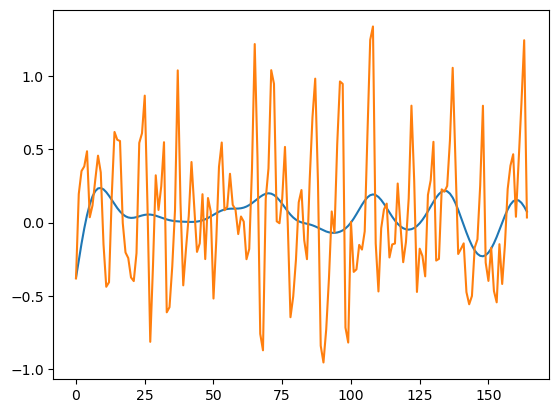

In [51]:
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)
tmp_filtered_arr = signal.filtfilt(b_lp_filter, a_lp_filter, df_clean_np)
plt.plot(tmp_filtered_arr[1,:].T)
plt.plot(df_clean_np[1,:].T)

In [15]:
import pandas as pd

# Charger le dataset dans un DataFrame
df = pd.read_csv("historical_48.csv")

print(df)

            modele           Variable         0         1         2         3  \
0    ACCESS-ESM1-5  tas_r10i1p1f1_ano -0.149256 -0.569931 -0.242309 -0.565678   
1    ACCESS-ESM1-5  tas_r11i1p1f1_ano -0.140877 -0.575243  0.327592  0.291398   
2    ACCESS-ESM1-5  tas_r12i1p1f1_ano  0.572594 -0.043521  0.419102  0.392004   
3    ACCESS-ESM1-5  tas_r13i1p1f1_ano  0.141619  0.266747  0.120515  0.395978   
4    ACCESS-ESM1-5  tas_r14i1p1f1_ano -0.118604  0.188049  0.580067  0.316786   
..             ...                ...       ...       ...       ...       ...   
251     MRI-ESM2-0   tas_r8i1p1f1_ano -0.003867  0.101668  0.456620  0.215709   
252     MRI-ESM2-0   tas_r9i1p1f1_ano  0.404228  0.059687 -0.056593  0.330903   
253     NorESM2-LM   tas_r1i1p1f1_ano  0.098773  0.776600 -0.186342  0.856486   
254     NorESM2-LM   tas_r2i1p1f1_ano -0.268393 -0.338989 -0.389957  0.204932   
255     NorESM2-LM   tas_r3i1p1f1_ano  0.167527  0.298653  1.206703  0.139703   

            4         5    

In [13]:


# lire les fichiers csv en tant que dataframe
# hist_GHG = pd.read_csv('hist-GHG_{}.csv'.format(region))
# hist_aer = pd.read_csv('hist-aer_{}.csv'.format(region))
# hist_nat = pd.read_csv('hist-nat_{}.csv'.format(region))
historical = pd.read_csv('historical_{}.csv'.format(region))
historical = historical[historical["modele"] == "IPSL-CM6A-LR"]
historical = historical.reset_index(drop=True)
# supprimer les deux premières colonnes de chaque dataframe
# hist_GHG = hist_GHG.iloc[:, 2:]
# hist_aer = hist_aer.iloc[:, 2:]
# hist_nat = hist_nat.iloc[:, 2:]
historical = historical.iloc[:, 2:]


# convertir chaque dataframe en tableau numpy (array)
# hist_GHG = np.array(hist_GHG)
# hist_aer = np.array(hist_aer)
# hist_nat = np.array(hist_nat)
historical = np.array(historical)

#Lissage 
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)

# hist_GHG = signal.filtfilt(b_lp_filter, a_lp_filter, hist_GHG)
# hist_aer = signal.filtfilt(b_lp_filter, a_lp_filter, hist_aer)
# hist_nat = signal.filtfilt(b_lp_filter, a_lp_filter, hist_nat)
historical = signal.filtfilt(b_lp_filter, a_lp_filter, historical)


# plt.plot(hist_GHG[:,:].T)
# Afficher le nombre de lignes et de colonnes du dataframe

# Définir le chemin où sauvegarder les fichiers .p
output_path = "/Users/dahmani/Desktop/GitPL/data_source_dr/Region48/"

# Sauvegarder chaque tableau numpy en tant que fichier .p
# with open(os.path.join(output_path, 'T_ghg_z{}v0.p'.format(region)), 'wb') as f:
#     pickle.dump(hist_GHG, f)
# with open(os.path.join(output_path, 'T_aer_z{}v0.p'.format(region)), 'wb') as f:
#     pickle.dump(hist_aer, f)
# with open(os.path.join(output_path, 'T_nat_z{}v0.p'.format(region)), 'wb') as f:
#     pickle.dump(hist_nat, f)
with open(os.path.join(output_path, 'T_hist_z{}v0.p'.format(region)), 'wb') as f:
    pickle.dump(historical, f)



In [11]:
# Open the .nc file using xarray
ds = xr.open_dataset('/Users/dahmani/Desktop/GitPL/data_source_dr/Region50/HadCRUT/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')
# Convert the dataset to a Pandas DataFrame
df = ds.to_dataframe().reset_index()
df
# Print the DataFrame
# df.to_csv("hadCrut.csv",index=False) 

time  realization  region abbrevs             names  tas_mean
0    1850          100      50     NAO  N.Atlantic-Ocean -0.041412
1    1851          100      50     NAO  N.Atlantic-Ocean  0.083646
2    1852          100      50     NAO  N.Atlantic-Ocean  0.203491
3    1853          100      50     NAO  N.Atlantic-Ocean -0.016122
4    1854          100      50     NAO  N.Atlantic-Ocean  0.123844
..    ...          ...     ...     ...               ...       ...
169  2019          100      50     NAO  N.Atlantic-Ocean  0.711238
170  2020          100      50     NAO  N.Atlantic-Ocean  0.782705
171  2021          100      50     NAO  N.Atlantic-Ocean  0.818779
172  2022          100      50     NAO  N.Atlantic-Ocean  0.854049
173  2023          100      50     NAO  N.Atlantic-Ocean  0.859843

[174 rows x 6 columns]

In [4]:
# Chemin d'accès vers les fichiers de modèle climatique
chemin_dacces = "/Users/dahmani/Desktop/GitPL/HadCRUT/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.region.nc"
region="50"
nouveau_dossier = "/Users/dahmani/Desktop/GitPL/HadCRUT"
if not os.path.exists(nouveau_dossier):
    os.mkdir(nouveau_dossier)

# Boucle pour parcourir tous les fichiers de modèle climatique
for fichier in glob.glob(chemin_dacces):
    # Charger le fichier de modèle climatique dans un objet Dataset
    ds = xr.open_dataset(fichier)

    # Extraire les données de la zone spécifiée
    zone_region = ds.sel(region=int(region))

# Écrire les données de la zone dans un nouveau fichier dans le nouveau dossier créé
    nouveau_fichier = os.path.join(nouveau_dossier, os.path.basename(fichier)[:-3] + f"_region{region}.nc")
    zone_region.to_netcdf(nouveau_fichier)

In [6]:


# sélectionner les colonnes "time" et "tas_mean" et les renommer
df_tas_mean = df.loc[:, ["time", "tas_mean"]]

# transposer la série obtenue en DataFrame
df_tas_mean = pd.DataFrame(df_tas_mean).T

# enregistrer le DataFrame sous le nom obs.npy
np.save("obs.npy", df_tas_mean.to_numpy())

In [8]:
import numpy as np
import xarray as xr

# Charger le fichier "obs.npy" et afficher le tableau numpy obtenu
obs = np.load("/Users/dahmani/Desktop/GitPL/data_source_dr/Region50/obs.npy")
print(obs)

# Créer un objet xarray.Dataset à partir du tableau numpy
ds = xr.Dataset(
    {
        "tas_mean": (["time"], obs[1, :]),
    },
    coords={
        "time": obs[0, :].astype(int),
    },
)

# Enregistrer l'objet xarray.Dataset dans un fichier netCDF
ds.to_netcdf("/Users/dahmani/Desktop/GitPL/data_source_dr/Region50/obs.nc")

[[ 1.85000000e+03  1.85100000e+03  1.85200000e+03  1.85300000e+03
   1.85400000e+03  1.85500000e+03  1.85600000e+03  1.85700000e+03
   1.85800000e+03  1.85900000e+03  1.86000000e+03  1.86100000e+03
   1.86200000e+03  1.86300000e+03  1.86400000e+03  1.86500000e+03
   1.86600000e+03  1.86700000e+03  1.86800000e+03  1.86900000e+03
   1.87000000e+03  1.87100000e+03  1.87200000e+03  1.87300000e+03
   1.87400000e+03  1.87500000e+03  1.87600000e+03  1.87700000e+03
   1.87800000e+03  1.87900000e+03  1.88000000e+03  1.88100000e+03
   1.88200000e+03  1.88300000e+03  1.88400000e+03  1.88500000e+03
   1.88600000e+03  1.88700000e+03  1.88800000e+03  1.88900000e+03
   1.89000000e+03  1.89100000e+03  1.89200000e+03  1.89300000e+03
   1.89400000e+03  1.89500000e+03  1.89600000e+03  1.89700000e+03
   1.89800000e+03  1.89900000e+03  1.90000000e+03  1.90100000e+03
   1.90200000e+03  1.90300000e+03  1.90400000e+03  1.90500000e+03
   1.90600000e+03  1.90700000e+03  1.90800000e+03  1.90900000e+03
   1.91000

In [28]:
import numpy as np

# charger le fichier obs.npy
obs = np.load("/Users/dahmani/Desktop/GitPL/data_source_dr/Region48/obs.npy")

# afficher le tableau numpy obtenu
print(obs[0])

[1850. 1851. 1852. 1853. 1854. 1855. 1856. 1857. 1858. 1859. 1860. 1861.
 1862. 1863. 1864. 1865. 1866. 1867. 1868. 1869. 1870. 1871. 1872. 1873.
 1874. 1875. 1876. 1877. 1878. 1879. 1880. 1881. 1882. 1883. 1884. 1885.
 1886. 1887. 1888. 1889. 1890. 1891. 1892. 1893. 1894. 1895. 1896. 1897.
 1898. 1899. 1900. 1901. 1902. 1903. 1904. 1905. 1906. 1907. 1908. 1909.
 1910. 1911. 1912. 1913. 1914. 1915. 1916. 1917. 1918. 1919. 1920. 1921.
 1922. 1923. 1924. 1925. 1926. 1927. 1928. 1929. 1930. 1931. 1932. 1933.
 1934. 1935. 1936. 1937. 1938. 1939. 1940. 1941. 1942. 1943. 1944. 1945.
 1946. 1947. 1948. 1949. 1950. 1951. 1952. 1953. 1954. 1955. 1956. 1957.
 1958. 1959. 1960. 1961. 1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969.
 1970. 1971. 1972. 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981.
 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993.
 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 20

In [32]:
import numpy as np

# Charger le fichier "obs.npy" et afficher le tableau numpy obtenu
obs = np.load("/Users/dahmani/Desktop/GitPL/data_source_dr/Region48/obs.npy")
print(obs)

# Vérifier les dimensions du tableau numpy
print(obs.shape)

# Extraire la colonne "year" à partir du tableau numpy
obs_years = obs[0]

# Afficher les années d'observation
print(obs_years)

# Vérifier que la variable "obs_years" contient les années d'observation correctes
if obs_years.size > 0:
    print(f"    {obs_years.size} years: from {obs_years[0]} to {obs_years[-1]}")
else:
    print("    Error: Obs data years are missing.")
    
# Vérifier si les données sont mises à l'échelle
obs_scale_flg = True
obs_scale = 2.0
if obs_scale_flg:
    print(f"Scaling Obs data by the factor of {obs_scale}")


[[ 1.85000000e+03  1.85100000e+03  1.85200000e+03  1.85300000e+03
   1.85400000e+03  1.85500000e+03  1.85600000e+03  1.85700000e+03
   1.85800000e+03  1.85900000e+03  1.86000000e+03  1.86100000e+03
   1.86200000e+03  1.86300000e+03  1.86400000e+03  1.86500000e+03
   1.86600000e+03  1.86700000e+03  1.86800000e+03  1.86900000e+03
   1.87000000e+03  1.87100000e+03  1.87200000e+03  1.87300000e+03
   1.87400000e+03  1.87500000e+03  1.87600000e+03  1.87700000e+03
   1.87800000e+03  1.87900000e+03  1.88000000e+03  1.88100000e+03
   1.88200000e+03  1.88300000e+03  1.88400000e+03  1.88500000e+03
   1.88600000e+03  1.88700000e+03  1.88800000e+03  1.88900000e+03
   1.89000000e+03  1.89100000e+03  1.89200000e+03  1.89300000e+03
   1.89400000e+03  1.89500000e+03  1.89600000e+03  1.89700000e+03
   1.89800000e+03  1.89900000e+03  1.90000000e+03  1.90100000e+03
   1.90200000e+03  1.90300000e+03  1.90400000e+03  1.90500000e+03
   1.90600000e+03  1.90700000e+03  1.90800000e+03  1.90900000e+03
   1.91000